In [20]:
# - pandas: For data manipulation and analysis (e.g., reading CSV, DataFrame operations).
# - nltk: Natural Language Toolkit for text processing tasks like tokenization.
# - numpy: For numerical operations, especially array manipulations.
# - scikit-learn: Comprehensive machine learning library for modeling, preprocessing, and metrics.
# - joblib: For saving and loading Python objects (like trained models or vectorizers).
# - skl2onnx: For converting scikit-learn models to ONNX format.
# - onnx: For working with ONNX (Open Neural Network Exchange) models.
# - onnxruntime: For running ONNX models.
# - matplotlib: For creating static, interactive, and animated visualizations.
# - seaborn: For making statistical graphics, built on top of matplotlib.
!pip install pandas nltk numpy scikit-learn joblib skl2onnx onnx onnxruntime matplotlib seaborn


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# ==============================================
# 1. IMPORTS
# ==============================================
# Standard library imports
import os                     # For interacting with the operating system (e.g., file paths, directory creation).
import re                     # For regular expression operations (pattern matching in text).
import string                 # For string constants (e.g., string.punctuation).
import time                   # For time-related functions (e.g., measuring execution time).
import json                   # For working with JSON data (saving/loading model parameters).

# Third-party library imports for data handling and numerical operations
import pandas as pd           # Data manipulation and analysis.
import numpy as np            # Numerical operations.
from scipy.sparse import hstack # For horizontally stacking sparse matrices (combining feature sets).

# NLTK (Natural Language Toolkit) for text processing
import nltk

# Scikit-learn imports for machine learning tasks
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets.
from sklearn.feature_extraction.text import TfidfVectorizer # For converting text data to TF-IDF features.
from sklearn.feature_extraction import DictVectorizer     # For converting lists of feature dictionaries to vectors.
from sklearn.feature_selection import SelectKBest, chi2    # For feature selection (SelectKBest with chi-squared test).
from sklearn.naive_bayes import MultinomialNB             # Naive Bayes classifier.
from sklearn.linear_model import LogisticRegression       # Logistic Regression classifier.
from sklearn.svm import LinearSVC                         # Linear Support Vector Classifier.
from sklearn.ensemble import RandomForestClassifier       # Random Forest classifier.
from sklearn.neural_network import MLPClassifier          # Multi-layer Perceptron (Neural Network) classifier.
from sklearn.metrics import (                             # For evaluating model performance.
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,      # For plotting ROC curves.
    auc,                  # For calculating Area Under the ROC Curve.
    roc_curve             # For computing ROC curve points.
)
import joblib                 # For saving and loading scikit-learn models/objects.

# ONNX related imports for model conversion and runtime
from skl2onnx import convert_sklearn  # Function to convert scikit-learn models to ONNX.
from skl2onnx.common.data_types import FloatTensorType # Data type for ONNX model inputs.
import onnxruntime as rt              # ONNX Runtime for model inference and verification.

# Plotting libraries
import matplotlib.pyplot as plt # For creating plots and visualizations.
import seaborn as sns           # For enhanced statistical visualizations.

print("Libraries imported successfully.")

Libraries imported successfully.


In [22]:
# ==============================================
# 2. NLTK RESOURCE CHECK
# ==============================================
# NLTK requires certain resources (like tokenizers and stopwords lists) to be downloaded.
# This section checks if they exist and downloads them if necessary.
print("\nChecking NLTK resources...")
try:
    nltk.data.find('tokenizers/punkt') # 'punkt' is a tokenizer for splitting text into sentences/words.
    print("- NLTK 'punkt' tokenizer found.")
except LookupError:
    print("Downloading NLTK 'punkt' tokenizer...")
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords') # 'stopwords' is a list of common words to ignore (e.g., "the", "is").
    print("- NLTK 'stopwords' corpus found.")
except LookupError:
    print("Downloading NLTK 'stopwords'...")
    nltk.download('stopwords')
print("NLTK check complete.")


Checking NLTK resources...
- NLTK 'punkt' tokenizer found.
- NLTK 'stopwords' corpus found.
NLTK check complete.


In [23]:
# ==============================================
# 3. DATA LOADING AND INITIAL PROCESSING
# ==============================================
# ==============================================
# DATASET INFORMATION
# ==============================================
#
# The dataset used for training and evaluation in this notebook is the
# "Phishing Email Dataset" sourced from Kaggle.
#
# - Kaggle Link: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
#
# - Description:
#   This dataset was compiled by researchers to study phishing email tactics.
#   It combines emails from a variety of sources (Enron, Ling, CEAS, Nazario,
#   Nigerian Fraud, and SpamAssassin datasets) to create a comprehensive resource.
#   The final dataset contains approximately 82,500 emails, with about
#   42,891 spam/phishing emails and 39,595 legitimate emails.
#   The key column used in this project is "text_combined", which amalgamates
#   the subject line, body, date, and sender email text.
#
# - Citation Request:
#   If using this dataset, please cite the following article:
#   Al-Subaiey, A., Al-Thani, M., Alam, N. A., Antora, K. F., Khandakar, A., & Zaman, S. A. U. (2024, May 19).
#   Novel Interpretable and Robust Web-based AI Platform for Phishing Email Detection.
#   ArXiv.org. https://arxiv.org/abs/2405.11619
#
# ==============================================
print("\nLoading dataset...")
df = None # Initialise DataFrame to None.
csv_file_path = "phishing_email.csv" # Path to the dataset.

# Simplified data loading, directly attempting to load the known columns.
try:
    print(f"Attempting to load columns: ['text_combined', 'label'] from {csv_file_path}...")
    df = pd.read_csv(csv_file_path, usecols=['text_combined', 'label'], encoding='latin-1')
    
    # Check if the 'label' column is text and needs mapping.
    if df['label'].dtype == 'object':
        print("Label column ('label') appears to be text. Attempting mapping...")
        # Define a map for various text label representations to numerical 0/1.
        label_map = {
            'Phishing Email': 1, 'Safe Email': 0, 'phishing': 1, 'safe': 0,
            'spam': 1, 'ham': 0, '1': 1, '0': 0
        }
        df['label_temp'] = df['label'].map(label_map) # Apply mapping.
        original_rows = len(df)
        df.dropna(subset=['label_temp'], inplace=True) # Drop rows where mapping failed.
        mapped_rows = len(df)
        if mapped_rows < original_rows:
            print(f"Warning: Dropped {original_rows - mapped_rows} rows due to unmappable labels.")
        df['label'] = df['label_temp'].astype('int8') # Convert mapped labels to int8.
        df.drop(columns=['label_temp'], inplace=True)
        print("Successfully mapped text labels in 'label' column to 0/1.")
    elif pd.api.types.is_numeric_dtype(df['label']): # If 'label' column is already numeric.
        print("Label column ('label') appears to be numeric. Ensuring int8 type.")
        df['label'] = df['label'].astype('int8') # Ensure it's int8 type.
    else:
        # This case should ideally not be reached if labels are either known text or numeric.
        print(f"Error: Unexpected data type '{df['label'].dtype}' in 'label' column.")
        exit() # Exit if label type is unhandled.
    print("Successfully loaded and processed 'label' column.")

except FileNotFoundError: # If the CSV file itself is not found.
    print(f"Error: {csv_file_path} not found. Please ensure it's in the correct directory.")
    exit()
except ValueError as ve: # If specified columns are not found or other pd.read_csv issues.
    print(f"Error loading specified columns from {csv_file_path}: {ve}")
    print("Please ensure 'text_combined' and 'label' columns exist in the CSV.")
    exit()
except Exception as e: # Catch any other unexpected errors during data loading.
    print(f"An unexpected error occurred during data loading: {e}")
    exit()

# Post-loading processing to ensure data integrity.
if df is not None:
    df.dropna(subset=['text_combined', 'label'], inplace=True) # Drop rows with missing text or labels.
    df['label'] = df['label'].astype('int8') # Ensure label is int8.
    df['text_combined'] = df['text_combined'].astype('string') # Use pandas' dedicated string type for efficiency.
    print(f"Dataset loaded. Shape after initial processing: {df.shape}")
    print(f"Columns present: {df.columns.tolist()}")
    print(f"Label distribution:\n{df['label'].value_counts(normalize=True)}") # Show class balance.
else:
    # This should not be reached if exit() was called above on error, but as a safeguard:
    print("Error: DataFrame not loaded.")
    exit()


Loading dataset...
Attempting to load columns: ['text_combined', 'label'] from phishing_email.csv...
Label column ('label') appears to be numeric. Ensuring int8 type.
Successfully loaded and processed 'label' column.
Dataset loaded. Shape after initial processing: (82486, 2)
Columns present: ['text_combined', 'label']
Label distribution:
label
1    0.519979
0    0.480021
Name: proportion, dtype: float64


In [24]:
# ==============================================
# 4. DEDUPLICATION
# ==============================================
print("\nRemoving duplicate emails based on 'text_combined'...")
initial_rows = len(df)
df = df.drop_duplicates(subset=['text_combined'])
print(f"Removed {initial_rows - len(df)} duplicates. Shape after deduplication: {df.shape}")


Removing duplicate emails based on 'text_combined'...
Removed 408 duplicates. Shape after deduplication: (82078, 2)


In [26]:
# ==============================================
# 5. TEXT CLEANING FUNCTION
# ==============================================
# Defines a function to preprocess raw email text.
# This cleaning is crucial for effective feature extraction, especially for TF-IDF.
def clean_text(text):
    """Cleans raw email text."""
    if pd.isna(text): return ""
    text = str(text).lower() # Convert to lowercase
    text = re.sub(r'<[^>]+>', ' ', text) # Remove HTML tags
    text = re.sub(r'&[a-z]+;', ' ', text) # Remove HTML entities
    text = re.sub(r'\b(x{10,}|\.{3,}|-{3,})\b', ' ', text) # Remove placeholders
    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE) # Remove quoted content
    text = re.sub(r"http\S+", "", text) # Remove URLs
    text = re.sub(r"\S+@\S+", "", text) # Remove email addresses
    text = re.sub(r"\d+", "", text) # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation)) # Remove punctuation
    text = re.sub(r'\b\w{1,2}\b', '', text) # Remove short words (1-2 chars)
    text = re.sub(r'\s+', ' ', text).strip() # Normalise whitespace
    return text

# Handcrafted Feature Engineering Rationale

In addition to TF-IDF features, which capture lexical content, a suite of over 50 handcrafted features is engineered. These features are designed to encapsulate various heuristic patterns and structural cues often indicative of phishing attempts, drawing inspiration from common phishing tactics discussed in the literature review.

The features are broadly categorised into:

* **Link Analysis:** Examining URLs for suspicious characteristics (e.g., IP addresses, shortened URLs, mismatches between link text and destination, deceptive domain patterns).
* **Header Analysis (Simulated):** Looking for anomalies in sender information, reply-to fields, and other header-like data if present in the `text_combined` field (e.g., free domain senders, brand impersonation in sender domain, mismatched From/Reply-To).
* **Text Characteristics:** Statistical properties of the text (word count, sentence length, use of uppercase, etc.).
* **Phishing Keywords & Urgency:** Presence and frequency of common phishing keywords and urgent phrases.
* **HTML/JavaScript Features (Simulated):** Based on regex matching for common HTML tags (`<form>`, `<script>`, `<iframe>`), JavaScript event handlers, and obfuscation patterns found in the raw `text_combined` content.
    * *Note:* The Chrome Extension will perform more accurate DOM-based extraction for these.
* **Readability & Style:** Punctuation usage, proportion of capitalised characters.
* **Visual Cues Analysis (Simulated):** Regex-based checks for patterns suggesting manipulated links, fake security images, etc.

The `extract_email_features` function implements these, operating on the raw `text_combined` input. The `text_combined` column from the dataset is described as "subject line, the body, date, and sender email text," meaning it contains a mix of structured and unstructured textual data, including potential raw HTML.

In [27]:
# ==============================================
# 6. HANDCRAFTED FEATURE EXTRACTION FUNCTION
# ==============================================
# Defines a function to extract domain-specific features from email content using regex and text analysis.
# These features are designed to capture signals indicative of phishing attempts.
def extract_email_features(text):
    """Extracts 50+ phishing-specific features from email text (simulated via regex)."""
    features = {}  # Initialise an empty dictionary to store features.
    original_text = str(text) if not pd.isna(text) else "" # Use the raw input text for regexes that need HTML/original structure.

    # `cleaned_text_for_counts` is used for NLTK tokenization and some text-based features.
    # It's derived by applying `clean_text` to the `original_text`.   
    cleaned_text_for_counts = clean_text(original_text)
    
    try:
        # NLTK for word and sentence tokenization.
        words = nltk.word_tokenize(cleaned_text_for_counts)
        sentences = nltk.sent_tokenize(cleaned_text_for_counts)
    except Exception: # Fallback if NLTK fails (e.g., resource not found or unexpected input).
        words = cleaned_text_for_counts.split() # Simple space-based word tokenization.
        # Simple sentence tokenization based on common terminators.
        sentences = [s.strip() for s in re.split(r'[.!?]+', cleaned_text_for_counts) if s.strip()]
        
    # --- Link Analysis (operates on `original_text` to see actual URLs) ---
    links = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', original_text)
    features['num_links'] = len(links)
    features['has_ip_url'] = int(bool(re.search(r'http[s]?://\d+\.\d+\.\d+\.\d+', original_text))) # Checks for URLs using IP addresses.
    features['has_shortened_url'] = int(bool(re.search(r'bit\.ly|goo\.gl|tinyurl|t\.co|is\.gd|ow\.ly|buff\.ly', original_text, re.I))) # Checks for common URL shorteners.
    features['domain_mismatch'] = int(bool(re.search(r'\[?https?://[^\s]+\]?.+\[?https?://[^\s]+\]?', original_text))) # Heuristic for mismatched link text and actual URL.

    link_text_patterns = re.findall(r'<a\s+[^>]*?href=["\'](http[^"\']+)["\'][^>]*?>(.*?)</a>', original_text, re.I | re.S)
    mismatches = 0
    suspicious_domains_in_link = 0
    for url, link_text_html in link_text_patterns:
        cleaned_link_text = re.sub(r'<[^>]+>', '', link_text_html).strip() # Clean the visible link text.
        # Check if visible link text looks like a URL but differs from the actual href.
        if re.match(r'https?://', cleaned_link_text, re.I) and url.lower() != cleaned_link_text.lower():
            mismatches += 1
        try:
            # Extract domain from the actual URL and check for suspicious keywords.
            domain_search = re.search(r'https?://(?:www\.)?([^/:]+)', url) # Exclude port from domain
            if domain_search:
                domain = domain_search.group(1)
                if re.search(r'(secure|login|verify|account|billing|password|confirm|support|service)', domain, re.I):
                    suspicious_domains_in_link += 1
        except: pass # Ignore errors if URL parsing fails for a specific link.
    features['link_text_url_mismatch'] = mismatches
    features['suspicious_domain_keyword_count'] = suspicious_domains_in_link
    features['deceptive_url_pattern'] = int(bool(re.search(r'paypal.*\.com(?!\.paypal\.com)|apple.*\.com(?!\.apple\.com)|google.*\.com(?!\.google\.com)', original_text, re.I))) # Checks for deceptive brand impersonation in URLs.
    features['has_url_encoding'] = int(bool(re.search(r'%[0-9A-Fa-f]{2}', original_text))) # Presence of URL-encoded characters.

    # --- Header Analysis (Simulated - Regex on `original_text` as full headers might not be in 'text_combined') ---
    features['has_mismatched_sender_replyto'] = int(bool(re.search(r'from:.*@([\w.-]+\.\w+).*reply-to:.*@(?!\1)[\w.-]+\.\w+', original_text, re.I | re.S)))
    sender_domain = None
    # Try to extract sender domain from "From:" lines.
    sender_match_complex = re.search(r'^from:.*<(\S+@\S+)>', original_text, re.I | re.MULTILINE)
    if not sender_match_complex:
         sender_match_complex = re.search(r'^from:\s*(\S+@\S+)', original_text, re.I | re.MULTILINE)
    if sender_match_complex: # If a "From:" line is found and an email can be extracted
        email_address_from_header = sender_match_complex.group(1)
        domain_match = re.search(r'@([\w.-]+\.\w+)', email_address_from_header)
        if domain_match:
            sender_domain = domain_match.group(1).lower()
    # Fallback if From: header parsing fails or isn't in expected format
    if not sender_domain:
        sender_match_general = re.search(r'(\b[A-Za-z0-9._%+-]+@[\w.-]+\.\w+\b)', original_text, re.I)
        if sender_match_general:
            email_address_general = sender_match_general.group(1)
            domain_match_general = re.search(r'@([\w.-]+\.\w+)', email_address_general)
            if domain_match_general:
                 sender_domain = domain_match_general.group(1).lower()

    if sender_domain:
        features['sender_is_free_domain'] = int(bool(re.match(r'(gmail|googlemail|hotmail|outlook|yahoo|aol)\.', sender_domain))) # Checks if sender uses a common free email provider.
        features['sender_claims_major_brand'] = int(bool(re.search(r'(paypal|apple|google|microsoft|amazon|netflix|facebook|bank|chase|wells\s*fargo|irs|gov)', sender_domain, re.I))) # Checks if sender domain claims to be a major brand (could be spoofed).
    else: # Default if no sender domain could be reliably extracted.
        features['sender_is_free_domain'] = 0
        features['sender_claims_major_brand'] = 0
    features['has_reply_to'] = int(bool(re.search(r'^reply-to:', original_text, re.I | re.MULTILINE))) # Presence of a "Reply-To" header.
    features['multiple_from_fields'] = int(len(re.findall(r'^from:', original_text, re.I | re.MULTILINE)) > 1) # Checks for multiple "From:" lines.
    features['suspicious_cc_bcc'] = int(bool(re.search(r'^(cc|bcc):.*undisclosed', original_text, re.I | re.MULTILINE))) # Checks for "undisclosed recipients" in CC/BCC.

    # --- Text Characteristics (based on NLTK tokenization of `cleaned_text_for_counts`) ---
    features['word_count'] = len(words)
    features['char_count'] = len(cleaned_text_for_counts)
    features['sentence_count'] = len(sentences)
    features['avg_word_length'] = np.mean([len(w) for w in words]) if words else 0.0
    features['avg_sentence_length'] = np.mean([len(s.split()) for s in sentences]) if sentences else 0.0
    features['forwarded_line_ratio'] = len(re.findall(r'^>', original_text, re.MULTILINE)) / max(1, len(original_text.split('\n'))) # Ratio of quoted lines.
    features['short_sentence_ratio'] = sum(1 for s in sentences if len(s.split()) < 5) / max(1, len(sentences)) if sentences else 0.0 # Ratio of sentences with less than 5 words.

    # --- Phishing Keywords & Urgency (based on NLTK tokenized words from `cleaned_text_for_counts`) ---
    phishing_keywords = [ # List of common phishing-related keywords.
        'verify', 'account', 'suspended', 'locked', 'urgent', 'immediately', 'action required',
        'password', 'login', 'signin', 'security', 'update', 'click', 'link', 'confirm', 'validate',
        'ssn', 'social security', 'credit card', 'bank', 'statement', 'invoice', 'payment',
        'alert', 'unusual', 'problem', 'issue', 'expire', 'limited', 'offer', 'winner', 'prize',
        'confidential', 'important', 'warning', 'fraud', 'access', 'restricted', 'failed', 'unable',
        'due', 'overdue', 'risk'
    ]
    phishing_keyword_set = set(phishing_keywords) # Convert to set for efficient lookup.
    features['phishing_keyword_count'] = sum(1 for word in words if word.lower() in phishing_keyword_set) # Count occurrences of phishing keywords.
    features['has_urgent_phrase'] = int(bool(re.search(r'\b(urgent|immediately|asap|now|important|alert|action required|limited time)\b', cleaned_text_for_counts, re.I))) # Presence of urgency-inducing phrases.
    features['has_attachment_mention'] = int(bool(re.search(r'\b(attachment|attached|document|file|report|invoice)\b', cleaned_text_for_counts, re.I))) # Mentions of attachments.
    features['has_generic_greeting'] = int(bool(re.search(r'\b(dear|hello)\s+(customer|user|member|valued|client|subscriber)\b', cleaned_text_for_counts, re.I))) # Use of generic greetings.
    features['has_threat_language'] = int(bool(re.search(r'\b(suspend|terminate|cancel|close|delete|remove|lock|disable)[\s\S]*(account|access)\b', cleaned_text_for_counts, re.I))) # Presence of threatening language.
    features['has_financial_request'] = int(bool(re.search(r'\b(payment|invoice|transfer|wire|bank|credit card|ssn|tax id)\b', cleaned_text_for_counts, re.I))) # Mentions of financial transactions/requests.

    # --- HTML/JavaScript Features (Simulated - Regex on `original_text`) ---
    features['html_content_ratio'] = len(re.findall(r'<[^>]+>', original_text)) / max(1, len(original_text)) # Ratio of HTML tags to total text length.
    features['has_forms'] = int(bool(re.search(r'<form', original_text, re.I))) # Presence of HTML forms.
    features['has_button_tag'] = int(bool(re.search(r'<button', original_text, re.I))) # Presence of <button> tags.
    features['input_field_count'] = len(re.findall(r'<input[^>]+>', original_text, re.I)) # Number of <input> fields.
    features['iframe_count'] = len(re.findall(r'<iframe', original_text, re.I)) # Number of <iframe> tags.
    features['hidden_element_count'] = len(re.findall(r'style\s*=\s*["\'].*?(display:\s*none|visibility:\s*hidden)', original_text, re.I)) # Count of hidden HTML elements.
    features['div_count'] = len(re.findall(r'<div', original_text, re.I)) # Count of <div> tags.
    # Checks if a form action points to a non-standard URL (not a major trusted domain).
    features['suspicious_form_action'] = int(bool(re.search(r'<form[^>]*action\s*=\s*["\'](?!#|/|mailto:)(?!https?://([\w-]+\.)*(paypal|google|apple|amazon|microsoft|facebook)\.com)[^"\']*["\']', original_text, re.I)))
    form_actions = re.findall(r'<form[^>]*action\s*=\s*["\'](.*?)["\']', original_text, re.I)
    features['external_form_submission'] = int(any(re.match(r'https?://', action) for action in form_actions)) # Checks if any form submits to an external URL.
    features['form_with_password_field'] = int(bool(re.search(r'<form.*<input[^>]*type\s*=\s*["\']password["\']', original_text, re.I | re.S))) # Checks for password input fields within forms.
    features['has_script_tag'] = int(bool(re.search(r'<script', original_text, re.I))) # Presence of <script> tags.
    features['script_tag_count'] = len(re.findall(r'<script', original_text, re.I)) # Count of <script> tags.
    features['event_handler_count'] = len(re.findall(r'on(click|load|mouseover|submit|focus|blur|change|keyup|keydown)\s*=', original_text, re.I)) # Count of JavaScript event handlers.
    features['has_eval_pattern'] = int(bool(re.search(r'eval\(', original_text, re.I))) # Presence of 'eval()'.
    features['has_document_write'] = int(bool(re.search(r'document\.write', original_text, re.I))) # Presence of 'document.write()'.
    features['has_window_open'] = int(bool(re.search(r'window\.open', original_text, re.I))) # Presence of 'window.open()'.
    features['has_settimeout_interval'] = int(bool(re.search(r'setTimeout|setInterval', original_text, re.I))) # Presence of setTimeout/setInterval.
    # Checks for common JavaScript obfuscation patterns.
    features['has_js_obfuscation'] = int(bool(re.search(r'(?<!\\)(\\x[0-9a-f]{2})|(?<!\\)(\\u[0-9a-f]{4})|String\.fromCharCode|unescape|encodeURIComponent', original_text, re.I)))


    # --- Basic Readability & Style (on `original_text`) ---
    features['exclamation_mark_count'] = original_text.count('!')
    features['question_mark_count'] = original_text.count('?')
    features['all_caps_char_ratio'] = sum(1 for c in original_text if c.isupper()) / max(1, len(original_text)) if original_text else 0.0

    # --- Visual Cues Analysis (Simulated - Regex on `original_text`) ---
    features['has_link_style_manipulation'] = int(bool(re.search(r'<a [^>]*style\s*=\s*["\'][^"\']*(color|text-decoration)[^"\']*["\']', original_text, re.I))) # Checks for links with manipulated styles.
    features['has_favicon_link'] = int(bool(re.search(r'<link[^>]*rel\s*=\s*["\'](?:shortcut )?icon["\']', original_text, re.I))) # Presence of favicon links.
    features['has_fake_security_image'] = int(bool(re.search(r'<img[^>]*src\s*=\s*["\'][^"\']*(lock|secure|verify|ssl|trust|shield|badge|cert)[^"\'.]*\.(png|gif|jpg|jpeg)["\']', original_text, re.I))) # Checks for images mimicking security indicators.
    features['has_status_bar_manipulation'] = int(bool(re.search(r'window\.status|onmouseover\s*=\s*["\']window\.status', original_text, re.I))) # Checks for attempts to manipulate the browser status bar.
    features['visual_deception_score'] = ( # Aggregate score for visual deception cues.
        float(features['has_fake_security_image']) + float(features['has_link_style_manipulation']) + float(features['has_status_bar_manipulation'])
    )

    # Ensure all features are numeric (float) and handle missing/NaN values.
    for key in features:
        if pd.isna(features[key]):
            features[key] = 0.0
        elif isinstance(features[key], bool):
            features[key] = float(features[key])
        else:
            try:
                features[key] = float(features[key])
            except (ValueError, TypeError):
                 # print(f"Warning: Could not convert feature '{key}' with value '{features[key]}' to float. Setting to 0.0.")
                 features[key] = 0.0
    return features

In [28]:
# ==============================================
# 7. APPLY CLEANING
# ==============================================
print("\nApplying text cleaning...")
start_time = time.time()
# Apply clean_text to the 'text_combined' column. This cleaned version is used by TF-IDF.
df['cleaned_text'] = df['text_combined'].apply(clean_text)
end_time = time.time()
print(f"Cleaning completed in {end_time - start_time:.2f} seconds.")


Applying text cleaning...
Cleaning completed in 11.62 seconds.


In [29]:
# ==============================================
# 8. TRAIN / TEST SPLIT
# ==============================================
# Split the dataset into training and testing sets to evaluate model performance on unseen data.
print("\nSplitting data into training and testing sets (80/20 split)...")

X = df # Features (includes 'text_combined' for handcrafted, 'cleaned_text' for TF-IDF).
y = df['label'] # Target variable.
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# test_size=0.2 means 20% of data for testing, 80% for training.
# stratify=y ensures that the class proportion is maintained in train and test splits.
# random_state=42 ensures reproducibility of the split.
print(f"Training set size: {len(X_train_df)} emails")
print(f"Testing set size: {len(X_test_df)} emails")
print(f"Training label distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing label distribution:\n{y_test.value_counts(normalize=True)}")


Splitting data into training and testing sets (80/20 split)...
Training set size: 65662 emails
Testing set size: 16416 emails
Training label distribution:
label
1    0.522007
0    0.477993
Name: proportion, dtype: float64
Testing label distribution:
label
1    0.521991
0    0.478009
Name: proportion, dtype: float64


# Feature Engineering Pipeline Justification

The feature engineering process involves several key steps:

1.  **TF-IDF Vectorization:**
    * Applied to the `cleaned_text`.
    * **`max_features=5000`**: Limits the vocabulary to the top 5000 terms by frequency, aiming to balance comprehensiveness with computational efficiency.
    * **`ngram_range=(1, 2)`**: Considers both individual words (unigrams) and pairs of adjacent words (bigrams) to capture more contextual information than unigrams alone.
    * **`min_df=5, max_df=0.7`**:
        * `min_df=5`: Ignores terms that appear in fewer than 5 documents, filtering out overly rare or potentially noisy terms.
        * `max_df=0.7`: Ignores terms that appear in more than 70% of documents, filtering out overly common terms that may lack discriminative power.
    * **`sublinear_tf=True`**: Applies logarithmic scaling to term frequencies (tf' = 1 + log(tf)). This helps to diminish the disproportionate effect of terms that appear very frequently within a single document compared to others.

2.  **Handcrafted Feature Extraction:**
    * Applied to the original `text_combined` column.
    * This leverages signals from raw content, including potential HTML structures, using the `extract_email_features` function.
    * The goal is to capture domain-specific heuristics not easily found by TF-IDF alone.

3.  **DictVectorizer for Handcrafted Features:**
    * Converts the dictionary of handcrafted features (output by `extract_email_features`) into a sparse numerical matrix.
    * This is necessary to prepare these features for combination with the TF-IDF matrix.

4.  **Feature Combination:**
    * TF-IDF features (from `cleaned_text`) and vectorized handcrafted features (from `text_combined`) are combined into a single feature matrix.
    * This is achieved using `scipy.sparse.hstack`, which concatenates the sparse matrices horizontally.

5.  **Feature Selection (SelectKBest):**
    * **`chi2` statistic**:
        * Chosen because it is suitable for non-negative features (our TF-IDF scores and 0/1 or count-based handcrafted features).
        * It assesses the dependence (or independence) between each feature and the class label, aiming to select features most likely to be relevant for classification.
    * **`k=2000`**:
        * The top 2000 features (based on the `chi2` scores) are selected.
        * This aims to further reduce dimensionality for a more compact and efficient final model, particularly beneficial for client-side deployment, while attempting to retain the most informative features.

In [30]:
# ==============================================
# 9. FEATURE ENGINEERING PIPELINE
# ==============================================
print("\nStarting Full Feature Engineering Pipeline...")

# --- 9.1 TF-IDF Vectorization (on 'cleaned_text') ---
print("Step 9.1: Performing TF-IDF Vectorization...")
start_time = time.time()
vectorizer = TfidfVectorizer(
    stop_words='english',     # Remove common English stop words.
    max_features=5000,        # Limit vocabulary size to the top 5000 terms.
    ngram_range=(1, 2),       # Consider both unigrams (single words) and bigrams (pairs of words).
    min_df=5,                 # Ignore terms that appear in less than 5 documents.
    max_df=0.7,               # Ignore terms that appear in more than 70% of documents (too common).
    analyzer='word',          # Analyze at the word level.
    sublinear_tf=True         # Apply sublinear TF scaling (1 + log(tf)).
)

# Fit the vectorizer on the training data's cleaned text and transform both train and test sets.
X_train_vec = vectorizer.fit_transform(X_train_df['cleaned_text'])
X_test_vec = vectorizer.transform(X_test_df['cleaned_text']) # Use transform for test data (no re-fitting).
end_time = time.time()
print(f"TF-IDF completed in {end_time - start_time:.2f} seconds. Train Shape: {X_train_vec.shape}, Test Shape: {X_test_vec.shape}")

# --- 9.2 Handcrafted Feature Extraction (on 'text_combined' which includes original HTML) ---
print("Step 9.2: Extracting handcrafted features...")
start_time = time.time()
# Apply the extract_email_features function to the 'text_combined' column (raw text with HTML).
manual_features_train = X_train_df['text_combined'].apply(extract_email_features).tolist()
manual_features_test = X_test_df['text_combined'].apply(extract_email_features).tolist()
end_time = time.time()
print(f"Handcrafted feature extraction completed in {end_time - start_time:.2f} seconds.")

# --- 9.3 Vectorize Handcrafted Features ---
# Convert the list of dictionaries (from handcrafted feature extraction) into a numerical sparse matrix.
print("Step 9.3: Vectorizing handcrafted features using DictVectorizer...")
start_time = time.time()
dict_vectorizer = DictVectorizer(sparse=True) # sparse=True for compatibility with TF-IDF sparse matrix.
try:
    X_train_manual = dict_vectorizer.fit_transform(manual_features_train)
    X_test_manual = dict_vectorizer.transform(manual_features_test)
    end_time = time.time()
    print(f"DictVectorizer completed in {end_time - start_time:.2f} seconds. Train Shape: {X_train_manual.shape}, Test Shape: {X_test_manual.shape}")
except Exception as e:
    print(f"Error during DictVectorizer fitting/transforming: {e}")
    exit()

# --- 9.4 Combine Features ---
# Horizontally stack the TF-IDF features and the handcrafted features.
print("Step 9.4: Combining TF-IDF and handcrafted features...")
start_time = time.time()
# Ensure both matrices are in CSR (Compressed Sparse Row) format for efficient hstack.
X_train_combined = hstack([X_train_vec.tocsr(), X_train_manual.tocsr()]).tocsr()
X_test_combined = hstack([X_test_vec.tocsr(), X_test_manual.tocsr()]).tocsr()
end_time = time.time()
print(f"Feature combination completed in {end_time - start_time:.2f} seconds.")
print(f"Combined Train Shape: {X_train_combined.shape}")
print(f"Combined Test Shape: {X_test_combined.shape}")

# --- 9.5 Feature Selection ---
# Reduce dimensionality by selecting the top k features using the chi-squared test.
k_features = 2000 # Target number of features to select.
print(f"Step 9.5: Selecting top {k_features} features using Chi2...")
start_time = time.time()
# Chi-squared test requires non-negative features.
if X_train_combined.min() < 0:
    print("Warning: Combined features contain negative values. Chi2 requires non-negative features.")
    print("Consider scaling (e.g., MinMaxScaler) or using a different selector (e.g., f_classif) if issues arise.")
# Ensure k is not more than the total number of available features.
actual_k = min(k_features, X_train_combined.shape[1])
if actual_k != k_features:
    print(f"Warning: Requested k={k_features} features, but only {X_train_combined.shape[1]} available. Selecting k={actual_k}.")
selector = SelectKBest(chi2, k=actual_k)
try:
    X_train_final = selector.fit_transform(X_train_combined, y_train)
    X_test_final = selector.transform(X_test_combined)
    end_time = time.time()
    print(f"Feature selection completed in {end_time - start_time:.2f} seconds.")
    print(f"Final Train Shape: {X_train_final.shape}")
    print(f"Final Test Shape: {X_test_final.shape}")
except ValueError as chi2_error: # Catch error if chi2 fails (e.g., due to negative values).
    print(f"Error during Chi2 feature selection: {chi2_error}")
    print("This often happens if features are negative. Try scaling data first or use f_classif.")
    exit()

print("\n[Full Feature Engineering Complete]")


Starting Full Feature Engineering Pipeline...
Step 9.1: Performing TF-IDF Vectorization...
TF-IDF completed in 18.08 seconds. Train Shape: (65662, 5000), Test Shape: (16416, 5000)
Step 9.2: Extracting handcrafted features...
Handcrafted feature extraction completed in 128.33 seconds.
Step 9.3: Vectorizing handcrafted features using DictVectorizer...
DictVectorizer completed in 1.87 seconds. Train Shape: (65662, 53), Test Shape: (16416, 53)
Step 9.4: Combining TF-IDF and handcrafted features...
Feature combination completed in 0.06 seconds.
Combined Train Shape: (65662, 5053)
Combined Test Shape: (16416, 5053)
Step 9.5: Selecting top 2000 features using Chi2...
Feature selection completed in 0.22 seconds.
Final Train Shape: (65662, 2000)
Final Test Shape: (16416, 2000)

[Full Feature Engineering Complete]



--- Starting Model Training & Evaluation (Full Features) ---

--- Training Multinomial Naive Bayes ---
Training completed in 0.02 seconds.
--- Evaluating Multinomial Naive Bayes ---
Evaluation completed in 0.01 seconds.
Accuracy: 0.8922
Precision (Phishing): 0.9243
Recall (Phishing): 0.8644
F1-Score (Phishing): 0.8933
Confusion Matrix:
[[7240  607]
 [1162 7407]]

--- Training Logistic Regression ---
Training completed in 16.94 seconds.
--- Evaluating Logistic Regression ---
Evaluation completed in 0.00 seconds.
Accuracy: 0.9631
Precision (Phishing): 0.9572
Recall (Phishing): 0.9729
F1-Score (Phishing): 0.9650
Confusion Matrix:
[[7474  373]
 [ 232 8337]]

--- Training Linear SVM (SVC) ---
Training completed in 2.06 seconds.
--- Evaluating Linear SVM (SVC) ---
Evaluation completed in 0.00 seconds.
Accuracy: 0.9649
Precision (Phishing): 0.9573
Recall (Phishing): 0.9763
F1-Score (Phishing): 0.9667
Confusion Matrix:
[[7474  373]
 [ 203 8366]]

--- Model Comparison Summary (Full Features) -

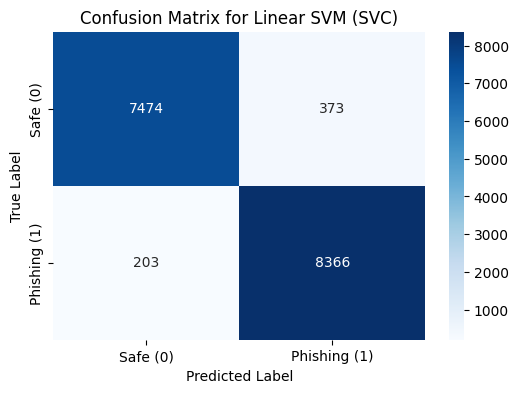

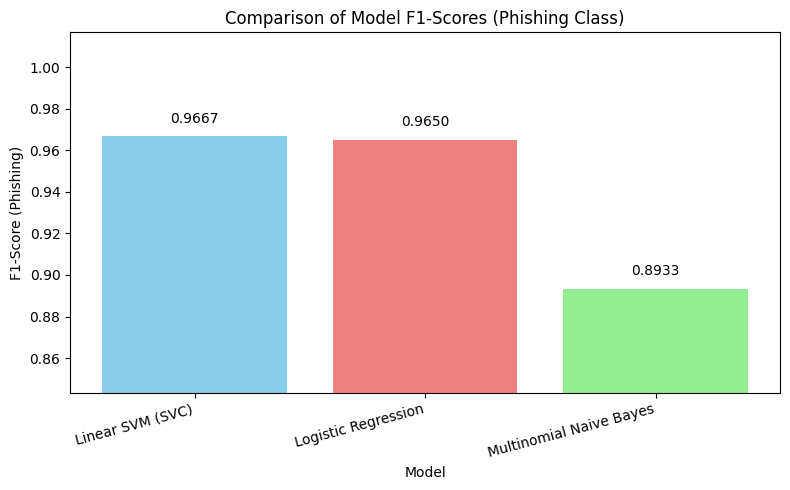

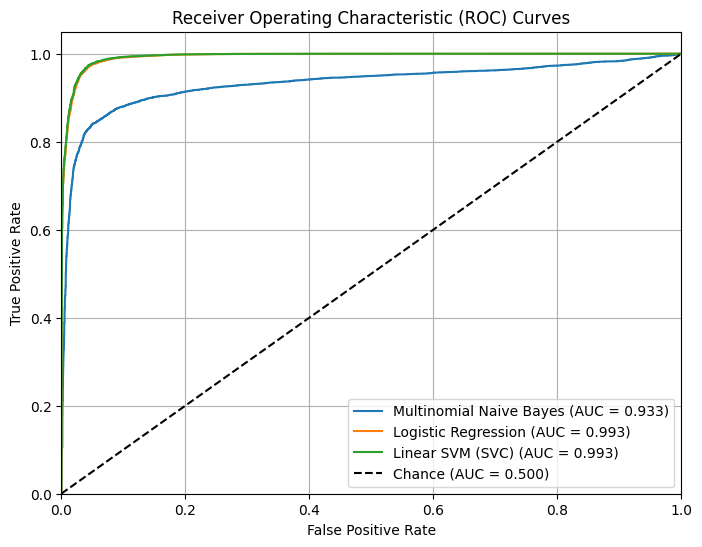


--- Error Analysis for Linear SVM (SVC) ---
Number of False Positives: 373
Number of False Negatives: 203

--- Sample False Positives (Legitimate emails flagged as Phishing) ---

FP Sample 1 (Index: 62685):
joseph brennan vupzesmcolumbiaedu worked well specific sentence bored girl always uses email azaz120azaz325info joseph brennan columbia university information technology thu 07 aug 2008 153225 0500 nice girl like chat spam...

FP Sample 2 (Index: 59985):
astrologycom feng shui fengshuirpastrologycom daily feng shui tip horoscopes love psychic readings predictions numerology chinese tarot astrology readings dear gordonhere daily feng shui tip thursday august 7 many us thinking vacations month itching spend quality time family friends also us already enjoyed special times great outdoors plain itching period someone know encountered poison ivy poison oak close personal quick remedy bring quicker relief sticky itchy situation take large piece watermelon rind meat melon rub gently affec

In [31]:
# ==============================================
# 10. MODEL TRAINING & EVALUATION
# ==============================================
print("\n--- Starting Model Training & Evaluation (Full Features) ---")
# Define a dictionary of models to train and compare.
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42, solver='liblinear'), # Increased max_iter for convergence.
    "Linear SVM (SVC)": LinearSVC(dual="auto", random_state=42, max_iter=2000), # dual="auto" is recommended for new versions.
    # RandomForest and MLP can be added back for comparison if desired.
    # "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    # "MLP Classifier (Simple NN)": MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='adam', max_iter=300, random_state=42, early_stopping=True, n_iter_no_change=10)
}

results = {} # To store performance metrics for each model.
trained_models = {} # To store the trained model objects.
model_predictions = {} # To store predictions on the test set for each model.
model_decision_scores = {} # To store decision scores or probabilities for ROC curve plotting.

# Iterate through each model, train it, and evaluate its performance.
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    try:
        # MultinomialNB requires non-negative features. Skip if X_train_final has negative values.
        if name == "Multinomial Naive Bayes" and X_train_final.min() < 0:
            print(f"Warning: Skipping {name} as final features contain negative values (required by MNB).")
            continue
        model.fit(X_train_final, y_train) # Train the model.
    except Exception as fit_err:
        print(f"Error training {name}: {fit_err}")
        continue # Skip to the next model if training fails.
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds.")
    trained_models[name] = model # Store the trained model.

    print(f"--- Evaluating {name} ---")
    start_time_eval = time.time()
    try:
        y_pred = model.predict(X_test_final) # Make predictions on the test set.
        model_predictions[name] = y_pred # Store these predictions.

        # Get decision function scores (for SVMs) or probability scores (for Logistic Regression, RF, etc.)
        # These are used for plotting ROC curves.
        if hasattr(model, "decision_function"):
            model_decision_scores[name] = model.decision_function(X_test_final)
        elif hasattr(model, "predict_proba"):
            # For probabilistic classifiers, get probabilities for the positive class (phishing).
            model_decision_scores[name] = model.predict_proba(X_test_final)[:, 1]
        else:
            # Fallback if neither is available (e.g., for MNB if not handled for negative values).
            model_decision_scores[name] = y_pred # Use predictions if scores aren't directly available.
    except Exception as pred_err:
        print(f"Error predicting with {name}: {pred_err}")
        continue
    eval_time = time.time() - start_time_eval
    print(f"Evaluation completed in {eval_time:.2f} seconds.")

    # Calculate standard performance metrics.
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0) # zero_division handles cases with no positive predictions.
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred) # Confusion matrix.
    try:
        # Generate classification report with target names.
        present_labels = sorted(list(np.unique(np.concatenate((y_test, y_pred)))))
        target_names = ['Safe (0)', 'Phishing (1)'] if set(present_labels) == {0, 1} else [f'Class {i}' for i in present_labels]
        report_str = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
    except Exception as report_error:
        print(f"Could not generate classification report: {report_error}")
        report_str = "N/A"

    # Store all results.
    results[name] = {
        "Accuracy": accuracy, "Precision (Phishing)": precision, "Recall (Phishing)": recall,
        "F1-Score (Phishing)": f1, "Confusion Matrix": cm, "Training Time (s)": train_time,
        "Evaluation Time (s)": eval_time, "Classification Report": report_str
    }
    # Print key metrics for the current model.
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Phishing): {precision:.4f}")
    print(f"Recall (Phishing): {recall:.4f}")
    print(f"F1-Score (Phishing): {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    # print(f"Classification Report:\n{report_str}") # Can be verbose, uncomment if needed.

# --- Model Comparison Summary ---
print("\n--- Model Comparison Summary (Full Features) ---")
if not results:
    print("No models were successfully trained and evaluated.")
else:
    # Create a DataFrame for easy comparison of model results, sorted by F1-score.
    results_df = pd.DataFrame(results).T.sort_values(by="F1-Score (Phishing)", ascending=False)
    print(results_df[['Accuracy', 'Precision (Phishing)', 'Recall (Phishing)', 'F1-Score (Phishing)', 'Training Time (s)', 'Evaluation Time (s)']].round(4))

    # Select the best model (explicitly LinearSVC for ONNX export, as per project choice).
    if "Linear SVM (SVC)" in trained_models:
        best_model_name = 'Linear SVM (SVC)'
        best_model = trained_models[best_model_name]
        print(f"\nSelected Model (Based on original choice for ONNX export): {best_model_name}")

        # Plot Confusion Matrix for the best model.
        plt.figure(figsize=(6, 4))
        sns.heatmap(results[best_model_name]["Confusion Matrix"], annot=True, fmt='d',
                    xticklabels=target_names, yticklabels=target_names, cmap="Blues")
        plt.title(f'Confusion Matrix for {best_model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print("\nError: Linear SVM (SVC) not found in trained models. Cannot proceed as planned.")
        best_model = None # Ensure best_model is None if LinearSVC wasn't trained.

# Plot F1-Scores for all trained models for comparison.
if results:
    f1_scores_map = {name: data["F1-Score (Phishing)"] for name, data in results.items()}
    # Sort models by F1-score for plotting.
    sorted_f1_models = sorted(f1_scores_map.items(), key=lambda item: item[1], reverse=True)
    
    model_names_sorted = [item[0] for item in sorted_f1_models]
    f1_values_sorted = [item[1] for item in sorted_f1_models]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(model_names_sorted, f1_values_sorted, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightsalmon'])
    plt.xlabel("Model")
    plt.ylabel("F1-Score (Phishing)")
    plt.title("Comparison of Model F1-Scores (Phishing Class)")
    plt.ylim(min(f1_values_sorted) - 0.05 if f1_values_sorted else 0.8, max(f1_values_sorted) + 0.05 if f1_values_sorted else 1.0) # Dynamic ylim
    for bar in bars: # Annotate bars with F1-score values.
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')
    plt.xticks(rotation=15, ha='right') # Rotate x-axis labels for better readability if many models.
    plt.tight_layout() # Adjust layout to prevent labels from overlapping.
    plt.show()

# Plot ROC Curves for all models that have decision_function or predict_proba.
plt.figure(figsize=(8, 6))
for name, model in trained_models.items():
    if name in model_decision_scores: # Check if scores were successfully stored for this model.
        # For models with predict_proba (like Logistic Regression, RandomForest).
        if hasattr(model, "predict_proba"):
            fpr, tpr, _ = roc_curve(y_test, model_decision_scores[name]) # Use stored scores.
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
        # For models with decision_function (like LinearSVC).
        elif hasattr(model, "decision_function"):
            fpr, tpr, _ = roc_curve(y_test, model_decision_scores[name]) # Use stored scores.
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
        # Note: MultinomialNB might not provide scores easily usable here without scaling,
        # or if it was skipped due to negative features.

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.500)') # Diagonal line for random chance.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Error Analysis for the Best Model (LinearSVC) ---
# Display samples of False Positives (FP) and False Negatives (FN) for qualitative analysis.
if 'best_model_name' in locals() and best_model_name == 'Linear SVM (SVC)' and best_model_name in model_predictions:
    y_pred_svc = model_predictions[best_model_name] # Get predictions for LinearSVC.
    
    # Identify indices of FPs (legitimate emails misclassified as phishing).
    fp_indices = X_test_df[(y_test == 0) & (y_pred_svc == 1)].index
    # Identify indices of FNs (phishing emails misclassified as legitimate).
    fn_indices = X_test_df[(y_test == 1) & (y_pred_svc == 0)].index
    
    print(f"\n--- Error Analysis for {best_model_name} ---")
    print(f"Number of False Positives: {len(fp_indices)}")
    print(f"Number of False Negatives: {len(fn_indices)}")

    print("\n--- Sample False Positives (Legitimate emails flagged as Phishing) ---")
    for i, index in enumerate(fp_indices[:3]): # Show up to 3 FP samples.
        print(f"\nFP Sample {i+1} (Index: {index}):")
        print(X_test_df.loc[index, 'text_combined'][:1000] + "...") # Print first 1000 characters.

    print("\n--- Sample False Negatives (Phishing emails flagged as Safe) ---")
    for i, index in enumerate(fn_indices[:3]): # Show up to 3 FN samples.
        print(f"\nFN Sample {i+1} (Index: {index}):")
        print(X_test_df.loc[index, 'text_combined'][:1000] + "...")
else:
    print("\nSkipping error sample display as LinearSVC was not the selected/available model for this analysis.")

print("\n--- Model Evaluation Complete ---")

# Artifact Export for Chrome Extension

The final step in the Python pipeline is to export all necessary components for the JavaScript-based Chrome extension. This ensures that the feature engineering and model inference can be replicated in the browser environment.

The exported artifacts include:

1.  **TF-IDF Vocabulary (`tfidf_vocabulary.json`):**
    * **Content:** A mapping of terms (words/n-grams) to their corresponding feature indices as learned by the `TfidfVectorizer`.
    * **Purpose:** Enables the JavaScript implementation to convert text tokens into the correct numerical feature indices for TF-IDF vector construction.

2.  **TF-IDF Data (`tfidf_idf_data.json`):**
    * **Content:**
        * Learned IDF (Inverse Document Frequency) weights for each term in the vocabulary.
        * Key `TfidfVectorizer` parameters (e.g., `ngram_range`, `max_features`, `min_df`, `max_df`, `sublinear_tf`).
    * **Purpose:** Allows for the precise replication of the TF-IDF calculation logic in JavaScript, ensuring consistency with the Python-trained model.

3.  **Handcrafted Feature Names (`handcrafted_feature_names.json`):**
    * **Content:** An ordered list of all handcrafted feature names.
    * **Purpose:** Ensures that the JavaScript side constructs its vector of handcrafted feature values in the exact same order as was used during training with `DictVectorizer` in Python. This is crucial for maintaining feature alignment.

4.  **Selector Information (`selector_info.json`):**
    * **Content:**
        * Indices of the features selected by `SelectKBest`.
        * The value of `k` (number of top features selected).
        * The total number of features before selection.
        * A breakdown: `num_tfidf_features` (e.g., 5000) and `num_manual_features` (e.g., 50+).
    * **Purpose:** This information is critical for the JavaScript code to:
        * Correctly combine the TF-IDF and handcrafted feature vectors (which are generated separately in JS).
        * Apply the feature selection by picking only the features at the specified indices from the combined vector. The breakdown helps ensure the indices are applied correctly relative to the concatenated feature set.

5.  **ONNX Model (`linear_svc_model.onnx`):**
    * **Content:** The trained `LinearSVC` model, converted to the Open Neural Network Exchange (ONNX) format.
    * **Purpose:** Facilitates efficient model inference directly in the browser using ONNX Runtime Web, avoiding the need for a server-side API call for predictions.

**Verification:**
The exported ONNX model is also verified by loading it with `onnxruntime` in Python and performing a sample prediction. This step aims to ensure its integrity and basic functionality before it's deployed within the Chrome extension.

In [32]:
# ==============================================
# 12. EXPORT ARTIFACTS FOR JAVASCRIPT EXTENSION
# ==============================================
# This section saves all necessary components (preprocessor states, selected model)
# so they can be loaded and used by the JavaScript-based Chrome Extension.
print("\n--- Exporting Artifacts ---")

output_dir = "extension_artifacts" # Define the directory to save artifacts.
if not os.path.exists(output_dir): # Create directory if it doesn't exist.
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")
else:
    print(f"Output directory already exists: {output_dir}")

# --- Save TF-IDF Vectorizer state ---
# Saves the vocabulary and IDF weights, plus other parameters needed to replicate TF-IDF in JS.
if 'vectorizer' in locals() and hasattr(vectorizer, 'vocabulary_') and vectorizer.vocabulary_:
    try:
        # 1. Save TF-IDF Vocabulary (term -> index map)
        py_vocab = {k: int(v) for k, v in vectorizer.vocabulary_.items()} # Ensure indices are standard integers.
        vocab_filepath = os.path.join(output_dir, 'tfidf_vocabulary.json')
        with open(vocab_filepath, 'w') as f:
            json.dump(py_vocab, f, indent=2)
        print(f"Saved TF-IDF vocabulary to {vocab_filepath} (Vocab size: {len(py_vocab)})")

        # 2. Save TF-IDF IDF weights and other relevant parameters for JS reconstruction.
        idf_values = vectorizer.idf_.tolist() # IDF weights as a list.
        ngram_min, ngram_max = vectorizer.ngram_range
        py_ngram_range = (int(ngram_min), int(ngram_max)) # Ensure ngram range are standard integers.
        py_max_features = None
        if vectorizer.max_features is not None:
            py_max_features = int(vectorizer.max_features)
        # Ensure min_df and max_df are standard Python float/int types for JSON serialisation.
        py_min_df = float(vectorizer.min_df) if isinstance(vectorizer.min_df, (np.floating, float)) else int(vectorizer.min_df)
        py_max_df = float(vectorizer.max_df) if isinstance(vectorizer.max_df, (np.floating, float)) else int(vectorizer.max_df)

        tfidf_idf_data_content = {
            'idf_weights': idf_values,
            'ngram_range': py_ngram_range,
            'max_features': py_max_features, # Max features used to build vocabulary.
            'use_idf': bool(vectorizer.use_idf), # Whether IDF weighting was used.
            'smooth_idf': bool(vectorizer.smooth_idf), # Whether smooth IDF was used.
            'sublinear_tf': bool(vectorizer.sublinear_tf), # Whether sublinear TF scaling was used.
            'min_df': py_min_df, # min_df used.
            'max_df': py_max_df  # max_df used.
        }
        idf_data_filepath = os.path.join(output_dir, 'tfidf_idf_data.json')
        with open(idf_data_filepath, 'w') as f:
            json.dump(tfidf_idf_data_content, f, indent=2)
        print(f"Saved TF-IDF IDF data and params to {idf_data_filepath} (IDF size: {len(idf_values)})")

    except Exception as e:
        print(f"Error saving TF-IDF vocabulary or IDF data: {e}")
else:
    print("TF-IDF vectorizer not available or not fitted for saving.")


# --- Save DictVectorizer state (Handcrafted Feature Names) ---
# Saves the ordered list of feature names from the DictVectorizer.
# This order is crucial for correctly constructing the handcrafted feature vector in JS.
if 'dict_vectorizer' in locals() and hasattr(dict_vectorizer, 'feature_names_') and dict_vectorizer.feature_names_:
    try:
        handcrafted_feature_names_list = dict_vectorizer.get_feature_names_out().tolist()
        hf_names_filepath = os.path.join(output_dir, 'handcrafted_feature_names.json')
        with open(hf_names_filepath, 'w') as f:
            json.dump(handcrafted_feature_names_list, f, indent=2) # Save the list of names.
        print(f"Saved Handcrafted Feature Names to {hf_names_filepath} ({len(handcrafted_feature_names_list)} features)")
    except Exception as e:
        print(f"Error saving Handcrafted Feature Names: {e}")
else:
    print("DictVectorizer (for handcrafted features) not available or not fitted for saving.")


# --- Save SelectKBest state (Selector Info) ---
# Saves the indices of the selected features, the value of 'k', and feature counts
# before and after selection. This is needed to replicate the feature selection in JS.
if 'selector' in locals() and selector is not None and hasattr(selector, 'get_support'):
    try:
        selected_indices = selector.get_support(indices=True).tolist() # Get indices of selected features.
        k_value = selector.k # The 'k' used in SelectKBest.
        # Ensure k is JSON serialisable (standard int or 'all' string).
        py_k = 'all' if isinstance(k_value, str) and k_value.lower() == 'all' else int(k_value)
        # Total features before selection (TF-IDF + Handcrafted).
        total_feats_before_selection = int(X_train_combined.shape[1]) if 'X_train_combined' in locals() else -1

        # Number of TF-IDF features (max_features or length of idf_ array).
        num_tfidf_feats = -1
        if 'vectorizer' in locals() and hasattr(vectorizer, 'idf_'):
            num_tfidf_feats = int(vectorizer.max_features) if vectorizer.max_features is not None else len(vectorizer.idf_)
        
        # Number of handcrafted features.
        num_manual_f = -1
        if 'dict_vectorizer' in locals() and hasattr(dict_vectorizer, 'feature_names_'):
            num_manual_f = len(dict_vectorizer.get_feature_names_out())

        selector_info_content = {
            'selected_indices': selected_indices,
            'k': py_k,
            'total_features_before_selection': total_feats_before_selection,
            'num_tfidf_features': num_tfidf_feats, # Number of features from TF-IDF before combining.
            'num_manual_features': num_manual_f   # Number of features from DictVectorizer before combining.
        }
        selector_filepath = os.path.join(output_dir, 'selector_info.json') # New filename
        with open(selector_filepath, 'w') as f:
            json.dump(selector_info_content, f, indent=2)
        print(f"Saved Selector Info to {selector_filepath} ({len(selected_indices)} indices selected)")
    except Exception as e:
        print(f"Error saving Selector Info: {e}")
else:
    # If feature selection was not performed, save placeholder info.
    print("Feature selector (SelectKBest) not used or not available for saving.")
    total_feats = int(X_train_combined.shape[1]) if 'X_train_combined' in locals() and hasattr(X_train_combined, 'shape') else -1
    num_tfidf_feats = int(vectorizer.max_features) if 'vectorizer' in locals() and vectorizer.max_features is not None else (len(vectorizer.idf_) if 'vectorizer' in locals() and hasattr(vectorizer, 'idf_') else -1)
    num_manual_f = len(dict_vectorizer.get_feature_names_out()) if 'dict_vectorizer' in locals() and hasattr(dict_vectorizer, 'feature_names_') else -1
    
    placeholder_selector_info = {
        'selected_indices': 'all', # Indicates all features were used.
        'k': 'all',
        'total_features_before_selection': total_feats,
        'num_tfidf_features': num_tfidf_feats,
        'num_manual_features': num_manual_f
    }
    selector_filepath = os.path.join(output_dir, 'selector_info.json') # New filename
    with open(selector_filepath, 'w') as f:
        json.dump(placeholder_selector_info, f, indent=2)
    print(f"Saved placeholder Selector Info to {selector_filepath}")


# --- Save the selected Model in ONNX format ---
# Converts the best scikit-learn model (LinearSVC) to ONNX format for use in JavaScript.
if 'best_model' in locals() and best_model is not None and 'X_train_final' in locals():
    try:
        num_final_features = int(X_train_final.shape[1]) # Number of features after SelectKBest.
        # Define the input type for the ONNX model (batch size of None, number of final features).
        initial_type = [('float_input', FloatTensorType([None, num_final_features]))]
        model_name_for_onnx = best_model_name if 'best_model_name' in locals() else 'N/A'
        
        print(f"\nConverting selected model ({model_name_for_onnx}) to ONNX...")
        # Convert the scikit-learn model to ONNX. target_opset specifies ONNX version compatibility.
        onnx_model = convert_sklearn(best_model, initial_types=initial_type, target_opset=11)
        
        onnx_model_filename = 'linear_svc_model.onnx' # Consistent filename for the extension
        onnx_model_path = os.path.join(output_dir, onnx_model_filename)
        with open(onnx_model_path, "wb") as f: # Save in binary write mode.
            f.write(onnx_model.SerializeToString())
        print(f"Saved ONNX model to {onnx_model_path}")

        # This checks if the conversion was successful and the model can be run.
        print("\nVerifying ONNX model with onnxruntime...")
        try:
            sess_options = rt.SessionOptions()
            sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED # Optional optimisation.
            # Create an inference session with the CPU execution provider.
            sess = rt.InferenceSession(onnx_model_path, sess_options=sess_options, providers=['CPUExecutionProvider'])
            input_name = sess.get_inputs()[0].name # Get the name of the input node.
            output_names = [output.name for output in sess.get_outputs()] # Get names of output nodes.
            print(f"  ONNX Input name: {input_name}, Output name(s): {output_names}")

            # Prepare a sample input from the test set for verification.
            if 'X_test_final' in locals() and X_test_final.shape[0] > 0:
                # Convert sparse matrix row to dense numpy array, ensure float32.
                sample_input_sparse = X_test_final[0]
                sample_input_dense = sample_input_sparse.toarray().astype(np.float32) if hasattr(sample_input_sparse, 'toarray') else sample_input_sparse.astype(np.float32)
                
                # Run inference.
                pred_onx = sess.run(output_names, {input_name: sample_input_dense})
                print(f"  ONNX test prediction output structure: {pred_onx}")
                # For scikit-learn classifiers, output is typically [label_output, probability_output (if available)].
                onnx_label = pred_onx[0][0] # First element is usually the predicted label.
                print(f"  ONNX test prediction label: {onnx_label}")
                if len(pred_onx) > 1: # Check for probabilities output.
                    if isinstance(pred_onx[1], list) and len(pred_onx[1]) > 0 and isinstance(pred_onx[1][0], dict):
                        print(f"  ONNX test prediction probabilities (dict format): {pred_onx[1][0]}")
                    elif isinstance(pred_onx[1], np.ndarray):
                         print(f"  ONNX test prediction probabilities (array format): {pred_onx[1][0]}") # Probabilities for each class.
                print("  ONNX model verification successful.")
            else:
                print("  Skipping ONNX model runtime verification: X_test_final is not available or empty.")
        except Exception as e:
            print(f"  Error verifying ONNX model with onnxruntime: {e}")
            print("  Please check onnxruntime installation and model compatibility.")

    except Exception as e:
        print(f"Error converting or saving ONNX model: {e}")
else:
    # Conditions for skipping ONNX export.
    if 'best_model' not in locals() or best_model is None: print("\nSkipping ONNX model saving: no best_model selected or available.")
    if 'X_train_final' not in locals(): print("\nSkipping ONNX model saving: X_train_final (needed for input shape) is unavailable.")

print("\n--- Artifact Export Complete ---")
# Print the absolute path to the artifacts directory for easy locating.
print(f"Artifacts saved in directory: {os.path.abspath(output_dir)}")


--- Exporting Artifacts ---
Output directory already exists: extension_artifacts
Saved TF-IDF vocabulary to extension_artifacts\tfidf_vocabulary.json (Vocab size: 5000)
Saved TF-IDF IDF data and params to extension_artifacts\tfidf_idf_data.json (IDF size: 5000)
Saved Handcrafted Feature Names to extension_artifacts\handcrafted_feature_names.json (53 features)
Saved Selector Info to extension_artifacts\selector_info.json (2000 indices selected)

Converting selected model (Linear SVM (SVC)) to ONNX...
Saved ONNX model to extension_artifacts\linear_svc_model.onnx

Verifying ONNX model with onnxruntime...
  ONNX Input name: float_input, Output name(s): ['label', 'probabilities']
  ONNX test prediction output structure: [array([0]), array([[-0.5224488]], dtype=float32)]
  ONNX test prediction label: 0
  ONNX test prediction probabilities (array format): [-0.5224488]
  ONNX model verification successful.

--- Artifact Export Complete ---
Artifacts saved in directory: C:\Users\ghar\(A) COM30

In [33]:
# Python Notebook Cell for Generating Ground Truth for Multiple Email Samples
# This cell is designed to take raw email content (subject, body text, body HTML, sender)
# for specific email samples and process them through the same Python feature engineering
# pipeline used for training the phishing detection model.
# The output is a series of Python-generated "expected values" (cleaned text, feature dictionaries,
# feature vectors) formatted as JavaScript 'const' declarations. These can then be
# copied into an HTML/JavaScript unit testing file (like test_content_logic.html)
# to compare against the JavaScript implementation of the feature engineering logic.

# ==============================================
# 1. TEXT CLEANING FUNCTION 
# ==============================================
def clean_text(text):
    """Cleans raw email text. This function should be identical to the one used for cleaning text
    before TF-IDF vectorization in your main model training pipeline.
    """
    if pd.isna(text): return ""
    text = str(text)
    text = text.lower() # Convert to lowercase
    text = re.sub(r'<[^>]+>', ' ', text) # Remove HTML tags
    text = re.sub(r'&[a-z0-9#]+;', ' ', text) # Remove HTML entities 
    text = re.sub(r'\b(x{10,}|\.{3,}|-{3,})\b', ' ', text) # Remove placeholders 
    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE) # Remove email quote lines 
    text = re.sub(r"http\S+", "", text) # Remove URLs
    text = re.sub(r"\S+@\S+", "", text) # Remove email addresses
    text = re.sub(r"\d+", "", text) # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'\b\w{1,2}\b', '', text) # Remove short words (1-2 characters)
    text = re.sub(r'\s+', ' ', text).strip() # Normalise whitespace (multiple spaces to one, trim ends)
    return text

# ==============================================
# 2. HANDCRAFTED FEATURE EXTRACTION FUNCTION 
# ==============================================
def extract_email_features(text):
    """Extracts 50+ phishing-specific features from email text (simulated via regex).
    This function should be identical to the one used for generating handcrafted features
    in your main model training pipeline. It operates on the 'original_text' which
    often includes HTML content for regex-based HTML feature extraction.
    """
    features = {}
    original_text = str(text) if not pd.isna(text) else ""
    # `cleaned_text_for_counts` is used for NLTK tokenization and some text-based features.
    # It's derived by applying `clean_text` to the `original_text`.
    cleaned_text_for_counts = clean_text(original_text)

    try:
        # NLTK for word and sentence tokenization (more linguistically aware)
        words = nltk.word_tokenize(cleaned_text_for_counts)
        sentences = nltk.sent_tokenize(cleaned_text_for_counts)
    except Exception: # Fallback if NLTK fails (e.g., resource not found)
        words = cleaned_text_for_counts.split()
        sentences = [s.strip() for s in re.split(r'[.!?]+', cleaned_text_for_counts) if s.strip()]

    # --- Link Analysis (Regex on original_text) ---
    links = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', original_text)
    features['num_links'] = len(links)
    features['has_ip_url'] = int(bool(re.search(r'http[s]?://\d+\.\d+\.\d+\.\d+', original_text)))
    features['has_shortened_url'] = int(bool(re.search(r'bit\.ly|goo\.gl|tinyurl|t\.co|is\.gd|ow\.ly|buff\.ly', original_text, re.I)))
    features['domain_mismatch'] = int(bool(re.search(r'\[?https?://[^\s]+\]?.+\[?https?://[^\s]+\]?', original_text))) # Heuristic

    link_text_patterns = re.findall(r'<a\s+[^>]*?href=["\'](http[^"\']+)["\'][^>]*?>(.*?)</a>', original_text, re.I | re.S)
    mismatches = 0
    suspicious_domains_in_link = 0
    for url, link_text_html in link_text_patterns:
        cleaned_link_text = re.sub(r'<[^>]+>', '', link_text_html).strip() # Clean link text by removing inner HTML tags
        if re.match(r'https?://', cleaned_link_text, re.I) and url.lower() != cleaned_link_text.lower():
            mismatches += 1
        try:
            # Extract domain from URL, excluding port numbers
            domain_search = re.search(r'https?://(?:www\.)?([^/:]+)', url)
            if domain_search:
                domain = domain_search.group(1)
                if re.search(r'(secure|login|verify|account|billing|password|confirm|support|service)', domain, re.I):
                    suspicious_domains_in_link += 1
        except: pass # Ignore errors in regex or domain parsing for a single link
    features['link_text_url_mismatch'] = mismatches
    features['suspicious_domain_keyword_count'] = suspicious_domains_in_link
    features['deceptive_url_pattern'] = int(bool(re.search(r'paypal.*\.com(?!\.paypal\.com)|apple.*\.com(?!\.apple\.com)|google.*\.com(?!\.google\.com)', original_text, re.I)))
    features['has_url_encoding'] = int(bool(re.search(r'%[0-9A-Fa-f]{2}', original_text)))
   
    # --- Header Analysis (Simulated - Regex on original_text) ---
    features['has_mismatched_sender_replyto'] = int(bool(re.search(r'from:.*@([\w.-]+\.\w+).*reply-to:.*@(?!\1)[\w.-]+\.\w+', original_text, re.I | re.S)))
    sender_domain = None
    # Try to extract sender domain from "From:" lines in the original_text
    sender_match_complex = re.search(r'^from:.*<(\S+@\S+)>', original_text, re.I | re.MULTILINE) # Catches "Name <email@domain.com>"
    if not sender_match_complex:
         sender_match_complex = re.search(r'^from:\s*(\S+@\S+)', original_text, re.I | re.MULTILINE) # Catches "email@domain.com"

    if sender_match_complex:
        email_address_from_header = sender_match_complex.group(1)
        domain_match = re.search(r'@([\w.-]+\.\w+)', email_address_from_header)
        if domain_match:
            sender_domain = domain_match.group(1).lower()
    
    # Fallback if From: header parsing fails or isn't in expected format in original_text
    if not sender_domain:
        # General regex to find any email address in the text, then extract its domain.
        # This is less reliable for identifying the *actual sender's domain* but provides a fallback.
        sender_match_general = re.search(r'(\b[A-Za-z0-9._%+-]+@[\w.-]+\.\w+\b)', original_text, re.I)
        if sender_match_general:
            email_address_general = sender_match_general.group(1)
            domain_match_general = re.search(r'@([\w.-]+\.\w+)', email_address_general)
            if domain_match_general:
                 sender_domain = domain_match_general.group(1).lower()

    if sender_domain:
        features['sender_is_free_domain'] = int(bool(re.match(r'(gmail|googlemail|hotmail|outlook|yahoo|aol)\.', sender_domain)))
        features['sender_claims_major_brand'] = int(bool(re.search(r'(paypal|apple|google|microsoft|amazon|netflix|facebook|bank|chase|wells\s*fargo|irs|gov)', sender_domain, re.I)))
    else:
        features['sender_is_free_domain'] = 0
        features['sender_claims_major_brand'] = 0
    features['has_reply_to'] = int(bool(re.search(r'^reply-to:', original_text, re.I | re.MULTILINE)))
    features['multiple_from_fields'] = int(len(re.findall(r'^from:', original_text, re.I | re.MULTILINE)) > 1)
    features['suspicious_cc_bcc'] = int(bool(re.search(r'^(cc|bcc):.*undisclosed', original_text, re.I | re.MULTILINE)))

    # --- Text Characteristics (based on NLTK tokenization of cleaned_text_for_counts) ---
    features['word_count'] = len(words)
    features['char_count'] = len(cleaned_text_for_counts) # Character count of the NLTK-tokenizable cleaned text
    features['sentence_count'] = len(sentences)
    features['avg_word_length'] = np.mean([len(w) for w in words]) if words else 0.0 # Average length of NLTK words
    features['avg_sentence_length'] = np.mean([len(s.split()) for s in sentences]) if sentences else 0.0 # Avg words per NLTK sentence
    features['forwarded_line_ratio'] = len(re.findall(r'^>', original_text, re.MULTILINE)) / max(1, len(original_text.split('\n')))
    features['short_sentence_ratio'] = sum(1 for s in sentences if len(s.split()) < 5) / max(1, len(sentences)) if sentences else 0.0

    # --- Phishing Keywords & Urgency (based on NLTK tokenized words from cleaned_text_for_counts) ---
    phishing_keywords = [
        'verify', 'account', 'suspended', 'locked', 'urgent', 'immediately', 'action required',
        'password', 'login', 'signin', 'security', 'update', 'click', 'link', 'confirm', 'validate',
        'ssn', 'social security', 'credit card', 'bank', 'statement', 'invoice', 'payment',
        'alert', 'unusual', 'problem', 'issue', 'expire', 'limited', 'offer', 'winner', 'prize',
        'confidential', 'important', 'warning', 'fraud', 'access', 'restricted', 'failed', 'unable',
        'due', 'overdue', 'risk'
    ]
    phishing_keyword_set = set(phishing_keywords)
    # Count keywords from NLTK-tokenized words (already lowercased by clean_text)
    features['phishing_keyword_count'] = sum(1 for word in words if word.lower() in phishing_keyword_set)
    features['has_urgent_phrase'] = int(bool(re.search(r'\b(urgent|immediately|asap|now|important|alert|action required|limited time)\b', cleaned_text_for_counts, re.I)))
    features['has_attachment_mention'] = int(bool(re.search(r'\b(attachment|attached|document|file|report|invoice)\b', cleaned_text_for_counts, re.I)))
    features['has_generic_greeting'] = int(bool(re.search(r'\b(dear|hello)\s+(customer|user|member|valued|client|subscriber)\b', cleaned_text_for_counts, re.I)))
    features['has_threat_language'] = int(bool(re.search(r'\b(suspend|terminate|cancel|close|delete|remove|lock|disable)[\s\S]*(account|access)\b', cleaned_text_for_counts, re.I)))
    features['has_financial_request'] = int(bool(re.search(r'\b(payment|invoice|transfer|wire|bank|credit card|ssn|tax id)\b', cleaned_text_for_counts, re.I)))

    # --- HTML/JavaScript Features (Simulated - Regex on original_text) ---
    features['html_content_ratio'] = len(re.findall(r'<[^>]+>', original_text)) / max(1, len(original_text))
    features['has_forms'] = int(bool(re.search(r'<form', original_text, re.I)))
    features['has_button_tag'] = int(bool(re.search(r'<button', original_text, re.I)))
    features['input_field_count'] = len(re.findall(r'<input[^>]+>', original_text, re.I))
    features['iframe_count'] = len(re.findall(r'<iframe', original_text, re.I))
    features['hidden_element_count'] = len(re.findall(r'style\s*=\s*["\'].*?(display:\s*none|visibility:\s*hidden)', original_text, re.I))
    features['div_count'] = len(re.findall(r'<div', original_text, re.I))
    features['suspicious_form_action'] = int(bool(re.search(r'<form[^>]*action\s*=\s*["\'](?!#|/|mailto:)(?!https?://([\w-]+\.)*(paypal|google|apple|amazon|microsoft|facebook)\.com)[^"\']*["\']', original_text, re.I)))
    form_actions = re.findall(r'<form[^>]*action\s*=\s*["\'](.*?)["\']', original_text, re.I)
    features['external_form_submission'] = int(any(re.match(r'https?://', action) for action in form_actions))
    features['form_with_password_field'] = int(bool(re.search(r'<form.*<input[^>]*type\s*=\s*["\']password["\']', original_text, re.I | re.S)))
    features['has_script_tag'] = int(bool(re.search(r'<script', original_text, re.I)))
    features['script_tag_count'] = len(re.findall(r'<script', original_text, re.I))
    features['event_handler_count'] = len(re.findall(r'on(click|load|mouseover|submit|focus|blur|change|keyup|keydown)\s*=', original_text, re.I))
    features['has_eval_pattern'] = int(bool(re.search(r'eval\(', original_text, re.I)))
    features['has_document_write'] = int(bool(re.search(r'document\.write', original_text, re.I)))
    features['has_window_open'] = int(bool(re.search(r'window\.open', original_text, re.I)))
    features['has_settimeout_interval'] = int(bool(re.search(r'setTimeout|setInterval', original_text, re.I)))
    # Corrected regex for JS obfuscation to avoid matching escaped backslashes
    features['has_js_obfuscation'] = int(bool(re.search(r'(?<!\\)(\\x[0-9a-f]{2})|(?<!\\)(\\u[0-9a-f]{4})|String\.fromCharCode|unescape|encodeURIComponent', original_text, re.I)))

    # --- Basic Readability & Style (on original_text) ---
    features['exclamation_mark_count'] = original_text.count('!')
    features['question_mark_count'] = original_text.count('?')
    features['all_caps_char_ratio'] = sum(1 for c in original_text if c.isupper()) / max(1, len(original_text)) if original_text else 0.0

    # --- Visual Cues Analysis (Simulated - Regex on original_text) ---
    features['has_link_style_manipulation'] = int(bool(re.search(r'<a [^>]*style\s*=\s*["\'][^"\']*(color|text-decoration)[^"\']*["\']', original_text, re.I)))
    features['has_favicon_link'] = int(bool(re.search(r'<link[^>]*rel\s*=\s*["\'](?:shortcut )?icon["\']', original_text, re.I)))
    features['has_fake_security_image'] = int(bool(re.search(r'<img[^>]*src\s*=\s*["\'][^"\']*(lock|secure|verify|ssl|trust|shield|badge|cert)[^"\'.]*\.(png|gif|jpg|jpeg)["\']', original_text, re.I)))
    features['has_status_bar_manipulation'] = int(bool(re.search(r'window\.status|onmouseover\s*=\s*["\']window\.status', original_text, re.I)))
    features['visual_deception_score'] = (
        float(features['has_fake_security_image']) + float(features['has_link_style_manipulation']) + float(features['has_status_bar_manipulation'])
    )

    # Fill NaN/None values and ensure all features are float for DictVectorizer
    for key in features:
        if pd.isna(features[key]):
            features[key] = 0.0
        elif isinstance(features[key], bool): # Convert bools to float 1.0 or 0.0
            features[key] = float(features[key])
        else:
            try: # Try to convert to float, if not possible (e.g. unexpected string), set to 0.0
                features[key] = float(features[key])
            except (ValueError, TypeError):
                 features[key] = 0.0
    return features

# ==============================================
# 4. MAIN GROUND TRUTH GENERATION HELPER FUNCTION
# ==============================================
def generate_python_ground_truth_for_js_test(email_name, email_subject, email_body_text, email_body_html, email_sender_address,
                                         py_vectorizer, py_dict_vectorizer, py_selector):
    """
    Processes a single email sample through the Python feature engineering pipeline
    and prints the results in a JavaScript-compatible format.
    """
    print(f"--- Generating Ground Truth for {email_name} ---")

    # Step 1: Clean text for TF-IDF input (Subject + Plain Text Body)
    # This input aligns with how JS `cleanTextForTfidf` is called for TF-IDF in the unit test.
    py_text_for_tfidf_cleaning = f"{email_subject or ''} {email_body_text or ''}"
    py_expected_cleaned_text_for_tfidf_input = clean_text(py_text_for_tfidf_cleaning)

    # Step 2: Prepare text for Handcrafted Feature extraction (Subject + HTML Body)
    # This aligns with how Python's `extract_email_features` was likely used during training
    # (operating on 'text_combined' which included HTML structure).
    py_original_text_for_handcrafted = f"{email_subject or ''} {email_body_html or ''}"
    py_expected_handcrafted_features_dict = extract_email_features(py_original_text_for_handcrafted)

    # Step 3: Generate TF-IDF Vector (Sparse Dictionary: {vocab_index_str: score})
    # Uses the cleaned text from Step 1.
    py_tfidf_vector_transformed = py_vectorizer.transform([py_expected_cleaned_text_for_tfidf_input])
    py_expected_tfidf_output_sparse_dict = {}
    coo_matrix_tfidf = py_tfidf_vector_transformed.tocoo() # Convert to Coordinate format for easy iteration
    for _, c_idx, val in zip(coo_matrix_tfidf.row, coo_matrix_tfidf.col, coo_matrix_tfidf.data):
        py_expected_tfidf_output_sparse_dict[str(c_idx)] = val # Key is the vocabulary index as a string

    # Step 4: Vectorize Handcrafted Features (Dense List, order from dict_vectorizer)
    # Uses the dictionary from Step 2.
    py_manual_vector_transformed = py_dict_vectorizer.transform([py_expected_handcrafted_features_dict])
    py_expected_manual_vector_list = py_manual_vector_transformed.toarray()[0].tolist()

    # Step 5: Combine TF-IDF and Handcrafted Feature Vectors (Dense List)
    # Order: TF-IDF features first, then handcrafted features.
    py_combined_vector_transformed = hstack([py_tfidf_vector_transformed.tocsr(), py_manual_vector_transformed.tocsr()]).tocsr()
    py_expected_combined_vector_list = py_combined_vector_transformed.toarray()[0].tolist()

    # Step 6: Apply Feature Selection (SelectKBest) (Dense List)
    py_final_vector_transformed = py_selector.transform(py_combined_vector_transformed)
    py_expected_final_vector_list = py_final_vector_transformed.toarray()[0].tolist()

    # --- Output for JavaScript Unit Test File ---
    # Create a JS-friendly variable name prefix from the email name.
    var_prefix = email_name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_").replace(":", "")

    print(f"\n\n// --- Python Expected Outputs for {email_name} ---")
    print(f"const {var_prefix}_py_expected_cleaned_text_for_tfidf_input = {json.dumps(py_expected_cleaned_text_for_tfidf_input)};")
    print(f"const {var_prefix}_py_expected_handcrafted_features_dict = {json.dumps(py_expected_handcrafted_features_dict, sort_keys=True, indent=4)};")
    print(f"const {var_prefix}_py_expected_tfidf_output_sparse_dict = {json.dumps(py_expected_tfidf_output_sparse_dict, sort_keys=True)};") # Sorting by key (index string)
    print(f"const {var_prefix}_py_expected_manual_vector_list = {json.dumps(py_expected_manual_vector_list)};")
    print(f"const {var_prefix}_py_expected_combined_vector_list = {json.dumps(py_expected_combined_vector_list)};")
    print(f"const {var_prefix}_py_expected_final_vector_list = {json.dumps(py_expected_final_vector_list)};")

    # For reference, print the input data that Python used for this email.
    # This helps ensure the JS test uses the identical raw inputs.
    print(f"\n// --- For JS Input - {email_name} - Ensure these match your JS variables ---")
    print(f"// const {var_prefix}_subject_js = {json.dumps(email_subject)};")
    # Truncate long body_text and body_html in this reference printout to keep console output manageable.
    body_text_print = (email_body_text[:200] + '...') if email_body_text and len(email_body_text) > 200 else email_body_text
    body_html_print = (email_body_html[:300] + '...') if email_body_html and len(email_body_html) > 300 else email_body_html # Truncate HTML if very long
    print(f"// const {var_prefix}_body_text_js = {json.dumps(body_text_print)}; // Full text length: {len(email_body_text or '')} chars")
    print(f"// const {var_prefix}_body_html_js = {json.dumps(body_html_print)}; // Full HTML length: {len(email_body_html or '')} chars")
    print(f"// const {var_prefix}_sender_js = {json.dumps(email_sender_address)};")
    print(f"// const {var_prefix}_emailData_js = {{ subject: {var_prefix}_subject_js, bodyText: {var_prefix}_body_text_js, bodyHtml: {var_prefix}_body_html_js, sender: {var_prefix}_sender_js }};")
    print(f"--- End of Ground Truth for {email_name} ---\n")


# ==============================================
# 5. DEFINE EMAIL SAMPLES AND GENERATE GROUND TRUTH
# ==============================================

# --- Email Sample 1: Trex IPTV (Phishing) ---
sample1_email_subject = "prayush10 ⚽🎥 Exclusive Offer: Watch Live TV and More with the Free IPTV Trial!"
sample1_email_body_text = """Top Stories of the Day: Sep 0, 2019 103882302891885308 ----- If you believe this has been sent to you in error, please safely unsubscribe"""
sample1_email_body_html = """<div class="adM">\n\n\n</div><div class="gmail_quote"><div class="adM">\n\n\n</div><u></u>\n\n<center>    \n\n    \n    \n    \n    \n\n<div>\n    <div class="m_-792212223616681504container">\n        <div class="m_-792212223616681504header"> TREX IPTV – THE ULTIMATE STREAMING EXPERIENCE </div>\n        <div class="m_-792212223616681504highlight">Exclusive access to unlimited entertainment!</div>\n        <div class="m_-792212223616681504content">\n            <p style="color:white"><b>Since 2020</b>, TREX IPTV has been revolutionizing entertainment with top-notch live sports, blockbuster movies, and family-friendly content.</p>\n            <p style="color:white">Be part of the future of streaming with <b>TREXIPTV-HD</b> and never miss a moment!</p>\n        </div>\n        <a href="https://storage.googleapis.com/warebirebim3ahadl9awm/warebirebim3ahadl9awm.html#4AwJoX141290hjPj157mkvrngfpeh13060VXTXJMIKOUDZXJJ94551AMKZ20585W37" class="m_-792212223616681504cta-button" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://storage.googleapis.com/warebirebim3ahadl9awm/warebirebim3ahadl9awm.html%234AwJoX141290hjPj157mkvrngfpeh13060VXTXJMIKOUDZXJJ94551AMKZ20585W37&source=gmail&ust=1747569845199000&usg=AOvVaw3XhNXGZut3VuxYlyYuS6oW"><img data-emoji="🚀" class="an1" alt="🚀" aria-label="🚀" draggable="false" src="https://fonts.gstatic.com/s/e/notoemoji/16.0/1f680/32.png" loading="lazy"> Watch Now</a>\n        <div class="m_-792212223616681504product-buttons">\n            <a href="https://storage.googleapis.com/yasouimoman/290425qdlkj.html#4dTsCP141290OBUK157tlrskhgdbj13060WMUWPXZLVUVMJIY94551NSWE20585i37" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://storage.googleapis.com/yasouimoman/290425qdlkj.html%234dTsCP141290OBUK157tlrskhgdbj13060WMUWPXZLVUVMJIY94551NSWE20585i37&source=gmail&ust=1747569845199000&usg=AOvVaw3gkKTrdiWn5rr_SvZgAMeu"><img data-emoji="⚽" class="an1" alt="⚽" aria-label="⚽" draggable="false" src="https://fonts.gstatic.com/s/e/notoemoji/16.0/26bd/32.png" loading="lazy"> Live Sports</a>\n            <a href="https://storage.googleapis.com/abresoumo/290425qdlkj.html#4YKcBO141290zDKJ157rhhervplpn13060ENLCJKDDCIGYZEA94551OVCP20585s37" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://storage.googleapis.com/abresoumo/290425qdlkj.html%234YKcBO141290zDKJ157rhhervplpn13060ENLCJKDDCIGYZEA94551OVCP20585s37&source=gmail&ust=1747569845199000&usg=AOvVaw3u-fPCB29qPetl4EfQfRfu"><img data-emoji="🎬" class="an1" alt="🎬" aria-label="🎬" draggable="false" src="https://fonts.gstatic.com/s/e/notoemoji/16.0/1f3ac/32.png" loading="lazy"> Movies & Series</a>\n            <a href="https://storage.googleapis.com/yasouimoman/290425qdlkj.html#4sfYOG141290SfXZ157kmqvnbjvlx13060AIGZQKXRBGDVKHH94551BYEW20585G37" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://storage.googleapis.com/yasouimoman/290425qdlkj.html%234sfYOG141290SfXZ157kmqvnbjvlx13060AIGZQKXRBGDVKHH94551BYEW20585G37&source=gmail&ust=1747569845199000&usg=AOvVaw1Q4Di9QiaiLwdtm0EnzWFc"><img data-emoji="👨‍👩‍👧‍👦" class="an1" alt="👨‍👩‍👧‍👦" aria-label="👨‍👩‍👧‍👦" draggable="false" src="https://fonts.gstatic.com/s/e/notoemoji/16.0/1f468_200d_1f469_200d_1f467_200d_1f466/32.png" loading="lazy"> Family & Kids</a>\n            <a href="https://storage.googleapis.com/abresoumo/290425qdlkj.html#4FPOad141290uoHr157ejgcoonzin13060ZONXSQMVLUZTQCM94551ICZR20585S37" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://storage.googleapis.com/abresoumo/290425qdlkj.html%234FPOad141290uoHr157ejgcoonzin13060ZONXSQMVLUZTQCM94551ICZR20585S37&source=gmail&ust=1747569845199000&usg=AOvVaw1QmNB3EW_-UMWNSNxVEIu6"><img data-emoji="⭐" class="an1" alt="⭐" aria-label="⭐" draggable="false" src="https://fonts.gstatic.com/s/e/notoemoji/16.0/2b50/32.png" loading="lazy"> Premium Channels</a>\n        </div>\n        <p style="font-size:11px;color:white">\n            2025 TREX IPTV | Access to Premium Entertainment\n            <a href="https://storage.googleapis.com/blama8523dkh1r2aj/zeinaros%20(1).html#6LZIfv141290RIwP157qscmlpmscw13060JRRPRYDXOCTQEJC94551RTAG20585S37" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://storage.googleapis.com/blama8523dkh1r2aj/zeinaros%2520(1).html%236LZIfv141290RIwP157qscmlpmscw13060JRRPRYDXOCTQEJC94551RTAG20585S37&source=gmail&ust=1747569845199000&usg=AOvVaw2DHtBMlRUK3kQ-FOsjYcmx">| CANCEL SUBSCRIPTION</a> <br>\n        </p>\n</div>\n</div></center><div class="yj6qo"></div><div class="adL">\n\n\n\n</div></div>"""
email1_py_sender = "dyxnl@xwyudcan.wonderfulmuse.it.com" 

generate_python_ground_truth_for_js_test(
    "Email 1 (Trex IPTV)",
    sample1_email_subject,
    sample1_email_body_text,
    sample1_email_body_html,
    email1_py_sender, 
    vectorizer, dict_vectorizer, selector 
)

# === Email Sample 2: Uber Email (Legitimate) ===
email2_py_subject = "Mark your calendar: Member Days is coming 16/05/2025!"
email2_py_body_text = "Get access to this members-only savings event. Unlock a week of savings on almost everything Now is the perfect time to start your 4 weeks free trial of Uber One! Sign up for member-only access to more deals, discounts, and perks than ever before. Open the app and you’ll see Member Days featured at the top of your home screen. Join Uber One to unlock these exclusive offers. Join Uber One Member Days is a special Uber One event from 16/05/2025 8:00 AM to 23/05/2025 11:59 PM local time. Certain offers are exclusive to Member Days. Check app for offer availability. Benefits available only for eligible stores and rides marked with the Uber One icon (as applicable). Other fees, exclusions & taxes may apply, but do not count towards order minimums or rides benefits. Minimum order may be required to receive the benefits for participating restaurants, participating grocery stores and participating non-grocery stores (as applicable). Membership savings applied as a reduction to service fees. Find more information about the benefits in the app. Subject to change. View the Renewable Membership T&Cs. Help Center Terms Unsubscribe Privacy Email Preferences Images or text may have been created or edited with AI. Uber Eats UK Limited First Floor, Aldgate Tower, 2 Leman Street, London, United Kingdom, E1 8FA Uber.com" # Get from extension console log for emailData.bodyText
email2_py_body_html = """<div id=":or" class="a3s aiL msg-2467302044623648108"><u></u>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  \n\n\n\n\n\n\n\n\n\n<div class="m_-2467302044623648108body" dir="ltr" style="background-color:#d6d6d5;margin:0;min-width:100%;padding:0;width:100%">\n<span id="m_-2467302044623648108Preheader" style="display:none;max-height:0px;font-size:0px;overflow:hidden">\nGet access to this members-only savings event.\n͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­\n͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­\n͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­\n͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­\n͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­\n͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­\n͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ­\n\n</span>\n<span id="m_-2467302044623648108TemplateUUID_020ced8e-c366-499a-80b8-60ac7a6e293f"></span>\n  \n<span id="m_-2467302044623648108WorkflowUUID_8623fb13-61ac-40ba-a16e-2783f3c6a5df"></span>    \n\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="background-color:#d6d6d5;border:0;border-collapse:collapse;border-spacing:0" bgcolor="#d6d6d5">\n<tbody>\n<tr>\n<td align="center" style="display:block">\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="border:0;border-collapse:collapse;border-spacing:0;max-width:700px" class="m_-2467302044623648108force700">\n<tbody>\n<tr>\n<td style="background-color:#ffffff">\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  \n  \n  \n  \n  \n\n\n\n\n\n  \n  \n  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    \n    \n\n\n\n\n\n    \n  \n    \n    \n    \n    \n  \n\n\n\n\n\n\n\n  \n\n\n  \n\n\n\n\n\n\n\n\n\n\n\n    \n    \n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<table border="0" cellspacing="0" cellpadding="0" align="center" bgcolor="#000000" role="presentation">\n  <tbody><tr>\n    <td style="font-size:1px;line-height:1px;vertical-align:top;width:700px;max-width:100%" valign="top" align="center">\n    \n    \n    \n    \n    \n\n\n\n\n\n\n    \n    <table border="0" cellpadding="0" cellspacing="0" style="width:100%">\n\n        \n        \n\n      \n        <tbody><tr>\n<td style="direction:ltr;text-align:left;text-align:center;padding-bottom:0px">\n    <div class="m_-2467302044623648108hide414">\n    \n    <img src="https://ci3.googleusercontent.com/meips/ADKq_NavguaEvkjvjvnDjpGnSLhSWkuTTNE9fJpUqT0FGFuKQmmmc_3-tMJy2byvT0n-tLc_bX79sAnw05ALeMIIfI4-bXfj2yrP59dh96iWjBsr3w0mLGyIZ9oNJrmV7iDUqMFUGHmCUp8A4oPw1RAXiLw2O8rMBSky=s0-d-e1-ft#https://tb-static.uber.com/prod/crm/email/2025/02/tam_u1/teaser_nonmember_animation01_uk_d_2x.gif" width="700" height="" style="clear:both;display:block;height:auto;max-width:700px;outline:none;text-decoration:none;width:100%;color:#ffffff;margin:0 auto" border="0" alt="" class="CToWUd a6T" data-bit="iit" tabindex="0"><div class="a6S" dir="ltr" style="opacity: 0.01; left: 660px; top: 668px;"><span data-is-tooltip-wrapper="true" class="a5q" jsaction="JIbuQc:.CLIENT"><button class="VYBDae-JX-I VYBDae-JX-I-ql-ay5-ays CgzRE" jscontroller="PIVayb" jsaction="click:h5M12e; clickmod:h5M12e;pointerdown:FEiYhc;pointerup:mF5Elf;pointerenter:EX0mI;pointerleave:vpvbp;pointercancel:xyn4sd;contextmenu:xexox;focus:h06R8; blur:zjh6rb;mlnRJb:fLiPzd;" data-idom-class="CgzRE" data-use-native-focus-logic="true" jsname="hRZeKc" aria-label="Download attachment " data-tooltip-enabled="true" data-tooltip-id="tt-c318" data-tooltip-classes="AZPksf" id="" jslog="91252; u014N:cOuCgd,Kr2w4b,xr6bB; 4:WyIjbXNnLWY6MTgzMjE0MDEyNTk3OTY1NDgzOCJd; 43:WyJpbWFnZS9qcGVnIl0."><span class="OiePBf-zPjgPe VYBDae-JX-UHGRz"></span><span class="bHC-Q" jscontroller="LBaJxb" jsname="m9ZlFb" soy-skip="" ssk="6:RWVI5c"></span><span class="VYBDae-JX-ank-Rtc0Jf" jsname="S5tZuc" aria-hidden="true"><span class="notranslate bzc-ank" aria-hidden="true"><svg viewBox="0 -960 960 960" height="20" width="20" focusable="false" class=" aoH"><path d="M480-336L288-528l51-51L444-474V-816h72v342L621-579l51,51L480-336ZM263.72-192Q234-192 213-213.15T192-264v-72h72v72H696v-72h72v72q0,29.7-21.16,50.85T695.96-192H263.72Z"></path></svg></span></span><div class="VYBDae-JX-ano"></div></button><div class="ne2Ple-oshW8e-J9" id="tt-c318" role="tooltip" aria-hidden="true">Download</div></span></div>  \n    </div>\n    <div class="m_-2467302044623648108show414" style="display:none;max-height:0px;overflow:hidden;padding:0">\n    \n    <img src="https://ci3.googleusercontent.com/meips/ADKq_NbX6Eg88YJZQAZyocLMk8pHs6VqMcvMLmK_SHjxhq4nerN4xKywWtgY7n-Om7ZsL44ZbN8rVcZimx0b5TbXqn2H5e6HWeYPSk5p289u4TgpPMXP0GZuiIwFWW0pUiGnbViX-E5AHvnDj7nEZhQCKeBLXOlE7wxs=s0-d-e1-ft#https://tb-static.uber.com/prod/crm/email/2025/02/tam_u1/teaser_nonmember_animation01_uk_m_2x.gif" width="414" height="" style="clear:both;display:block;height:auto;max-width:430px;outline:none;text-decoration:none;width:100%;color:#ffffff;margin:0 auto" border="0" alt="" class="CToWUd a6T" data-bit="iit" tabindex="0"><div class="a6S" dir="ltr" style="opacity: 0.01; left: -8px; top: -8px;"><span data-is-tooltip-wrapper="true" class="a5q" jsaction="JIbuQc:.CLIENT"><button class="VYBDae-JX-I VYBDae-JX-I-ql-ay5-ays CgzRE" jscontroller="PIVayb" jsaction="click:h5M12e; clickmod:h5M12e;pointerdown:FEiYhc;pointerup:mF5Elf;pointerenter:EX0mI;pointerleave:vpvbp;pointercancel:xyn4sd;contextmenu:xexox;focus:h06R8; blur:zjh6rb;mlnRJb:fLiPzd;" data-idom-class="CgzRE" data-use-native-focus-logic="true" jsname="hRZeKc" aria-label="Download attachment " data-tooltip-enabled="true" data-tooltip-id="tt-c319" data-tooltip-classes="AZPksf" id="" jslog="91252; u014N:cOuCgd,Kr2w4b,xr6bB; 4:WyIjbXNnLWY6MTgzMjE0MDEyNTk3OTY1NDgzOCJd; 43:WyJpbWFnZS9qcGVnIl0."><span class="OiePBf-zPjgPe VYBDae-JX-UHGRz"></span><span class="bHC-Q" jscontroller="LBaJxb" jsname="m9ZlFb" soy-skip="" ssk="6:RWVI5c"></span><span class="VYBDae-JX-ank-Rtc0Jf" jsname="S5tZuc" aria-hidden="true"><span class="notranslate bzc-ank" aria-hidden="true"><svg viewBox="0 -960 960 960" height="20" width="20" focusable="false" class=" aoH"><path d="M480-336L288-528l51-51L444-474V-816h72v342L621-579l51,51L480-336ZM263.72-192Q234-192 213-213.15T192-264v-72h72v72H696v-72h72v72q0,29.7-21.16,50.85T695.96-192H263.72Z"></path></svg></span></span><div class="VYBDae-JX-ano"></div></button><div class="ne2Ple-oshW8e-J9" id="tt-c319" role="tooltip" aria-hidden="true">Download</div></span></div>  \n    </div>\n</td>    \n</tr>      \n    \n\n\n    </tbody></table>\n    \n\n      \n    </td>\n  </tr>\n\n</tbody></table>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="width:100%">\n<tbody>\n\n\n\n<tr>\n<td align="left" style="direction:ltr;text-align:left;padding-left:14px;padding-right:14px;padding-top:40px;padding-bottom:40px;background-color:#ffffff">\n<table border="0" cellpadding="0" cellspacing="0" style="width:100%">\n<tbody>\n<tr>\n<td style="direction:ltr;text-align:left">\n\n<table border="0" cellpadding="0" cellspacing="0" class="m_-2467302044623648108t10of12" align="center" style="Margin:0 auto;max-width:560px;width:100%">\n<tbody><tr>\n<td style="direction:ltr;text-align:left;padding-left:12px;padding-right:12px">\n<table border="0" cellpadding="0" cellspacing="0" width="100%" align="left" style="table-layout:fixed;width:100%">\n<tbody>\n\n\n\n\n\n\n\n<tr>\n<td style="direction:ltr;text-align:center;padding-top:0;padding-bottom:20px">\n<h1 style="Margin:0;padding:0;font-family:'Uber Move','Helvetica Neue',Helvetica,Arial,sans-serif;font-size:34px;line-height:40px;font-weight:500;color:#000000">\n    \n\n    \n\n    \n\n\n\n    \n\n        \n\n            \n            \n\n            Unlock a week of savings on almost everything\n\n\n        \n\n\n\n</h1>\n</td>\n</tr>\n\n\n\n\n\n<tr>\n<td style="direction:ltr;text-align:center;font-family:'Uber Move Text','Helvetica Neue',Helvetica,Arial,sans-serif;font-size:20px;line-height:26px;color:#000000;padding-top:0;padding-bottom:25px"><div>Now is the perfect time to start your 4 weeks free trial of <span class="il">Uber</span> One! Sign up for member-only access to more deals, discounts, and perks than ever before.<br>\n<br>\nOpen the app and you’ll see Member Days featured at the top of your home screen. Join <span class="il">Uber</span> One to unlock these exclusive offers.</div>\n\n</td>\n</tr>\n\n\n<tr>\n<td style="direction:ltr;text-align:center;padding-top:0px;padding-bottom:6px">\n\n\n<div lang="x-btn" style="font-family:'Uber Move Text','Helvetica Neue',Helvetica,Arial,sans-serif;font-weight:700;font-size:16px;line-height:22px">\n<a href="https://rides.sng.link/Aw5zn/yjvm?_dl=uber%3A%2F%2Fplus%3Fentry-point%3Demail%26access-point%3Demail%26pass-campaign%3Dupsell_gcrmmemberdaysteaser&_forward_params=1&_smtype=3&partner=crm&pcid=bloc_020ced8e-c366-499a-80b8-60ac7a6e293f&u_action_id=0e39ae89-40f3-4df9-96a8-496b14a150d1&utm_content=045ce0b8-2295-33c9-89af-3f9794e57e6a&~customer_keyword=045ce0b8-2295-33c9-89af-3f9794e57e6a" style="background-color:#000000;border-color:#000000;color:#ffffff;border-radius:0px;border-style:solid;border-width:13px 18px;display:inline-block;letter-spacing:1px;max-width:300px;min-width:100px;text-align:center;text-decoration:none" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://rides.sng.link/Aw5zn/yjvm?_dl%3Duber%253A%252F%252Fplus%253Fentry-point%253Demail%2526access-point%253Demail%2526pass-campaign%253Dupsell_gcrmmemberdaysteaser%26_forward_params%3D1%26_smtype%3D3%26partner%3Dcrm%26pcid%3Dbloc_020ced8e-c366-499a-80b8-60ac7a6e293f%26u_action_id%3D0e39ae89-40f3-4df9-96a8-496b14a150d1%26utm_content%3D045ce0b8-2295-33c9-89af-3f9794e57e6a%26~customer_keyword%3D045ce0b8-2295-33c9-89af-3f9794e57e6a&source=gmail&ust=1747783002575000&usg=AOvVaw0P9eoyUC9LYBIJh81bSkEM"><span style="float:left;text-align:left">Join <span class="il">Uber</span> One</span> <span style="float:right;padding-top:3px;display:inline-block"> <img src="https://ci3.googleusercontent.com/meips/ADKq_NYFLgPeO9pBo_rKe7wJlBeZksTCYXunzhmbLqyd10uTIWig6Gtqxzlk2oB80UAYFBKzgU35GnNQgF8OIOOuDE6EtrYjwNK_V_-aqi0DFTSHk0BMW27sY4I7cQySfOJa8PQXatCGbqEGY-xM=s0-d-e1-ft#https://d1a3f4spazzrp4.cloudfront.net/emails/2018/global/arrows/arrow2_white_left.png" width="14" height="13" style="Margin-left:7px;clear:both;display:block;margin-top:2px;max-width:100%;outline:none;text-decoration:none" alt="" class="CToWUd" data-bit="iit">\n</span>\n </a>\n</div>\n\n\n</td>\n</tr>\n\n\n \n\n</tbody></table>\n</td>\n</tr>\n</tbody></table>\n\n</td>\n</tr>\n</tbody></table>\n</td>\n</tr>\n</tbody></table>\n\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="border:0;border-collapse:collapse;border-spacing:0;margin:auto;max-width:700px">\n<tbody>\n<tr>\n<td align="center">\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="background-color:#fff;border:0;border-collapse:collapse;border-spacing:0;margin:auto" bgcolor="#ffffff">\n<tbody>\n<tr>\n<td align="center">\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="border:0;border-collapse:collapse;border-spacing:0">\n<tbody>\n<tr>\n<td align="center" style="background-color:#ffffff">\n<table border="0" cellpadding="0" cellspacing="0" width="100%" style="border:0;border-collapse:collapse;border-spacing:0">\n<tbody>\n<tr>\n<td>\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="border:0;border-collapse:collapse;border-spacing:0">\n<tbody>\n<tr>\n<td>\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="border:0;border-collapse:collapse;border-spacing:0">\n<tbody>\n<tr>\n<td>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  \n\n\n\n\n\n\n\n\n\n\n\n\n    \n\n    \n        \n        \n        \n        \n        \n        \n        \n        \n        \n          \n        \n\n    \n\n\n\n\n\n\n\n\n\n\n  \n\n\n\n\n\n\n\n\n    \n  \n        \n  \n\n  \n          \n  \n  \n\n\n\n\n\n<table width="100%" border="0" cellpadding="0" cellspacing="0" style="border-collapse:collapse;width:100%">\n    <tbody>\n\n      <tr>\n      <td align="left" style="direction:ltr;text-align:left;background-color:#000000;padding-left:14px;padding-right:14px;padding-top:15px;padding-bottom:10px">\n        <table border="0" cellpadding="0" cellspacing="0" style="border-collapse:collapse;width:100%">\n          <tbody><tr>\n            <td style="direction:ltr;text-align:left">\n\n        <table border="0" cellpadding="0" cellspacing="0" class="m_-2467302044623648108t10of12" align="center" style="Margin:0 auto;border-collapse:collapse;max-width:560px;width:100%">\n          <tbody><tr>\n            <td style="direction:ltr;text-align:left;padding-bottom:0px;padding-left:12px;padding-right:12px;padding-top:0px">\n              <table border="0" cellpadding="0" cellspacing="0" width="100%" align="left" style="border-collapse:collapse;table-layout:fixed;width:100%">\n                <tbody><tr>\n                  <td style="direction:ltr;text-align:left;color:#ffffff;font-family:'Uber Move Text','HelveticaNeue',Helvetica,Arial,sans-serif;font-size:12px;font-weight:normal;line-height:18px;padding-bottom:7px;padding-top:7px"><div>Member Days is a special <span class="il">Uber</span> One event from 16/05/2025 8:00 AM to 23/05/2025 11:59 PM local time. Certain offers are exclusive to Member Days. Check app for offer availability.</div>\n</td>\n                </tr>\n              </tbody></table>\n            </td>\n          </tr>\n        </tbody></table>\n        \n              </td>\n            </tr>\n          </tbody></table>\n      </td>\n    </tr>\n \n</tbody></table>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    \n\n\n\n\n\n    \n    \n\n\n\n\n\n\n\n  \n\n\n\n  \n\n\n\n\n\n\n\n  \n  \n\n    \n    \n    \n\n    \n    \n      \n      \n    \n\n\n\n      \n      <table width="100%" border="0" cellpadding="0" cellspacing="0" style="border-collapse:collapse;width:100%">\n        <tbody>\n\n            <tr>\n            <td align="left" style="direction:ltr;text-align:left;background-color:#000000;padding-left:14px;padding-right:14px;padding-top:10px;padding-bottom:15px">\n              <table border="0" cellpadding="0" cellspacing="0" style="border-collapse:collapse;width:100%">\n                <tbody><tr>\n                  <td style="direction:ltr;text-align:left">\n      \n                  <table border="0" cellpadding="0" cellspacing="0" class="m_-2467302044623648108t10of12" align="center" style="Margin:0 auto;border-collapse:collapse;max-width:560px;width:100%">\n                    <tbody><tr>\n                      <td style="direction:ltr;text-align:left;padding-bottom:0px;padding-left:12px;padding-right:12px;padding-top:0px">\n                        <table border="0" cellpadding="0" cellspacing="0" width="100%" align="left" style="border-collapse:collapse;table-layout:fixed;width:100%">\n                          <tbody><tr>\n                            <td style="direction:ltr;text-align:left;color:#ffffff;font-family:'Uber Move Text','HelveticaNeue',Helvetica,Arial,sans-serif;font-size:12px;font-weight:normal;line-height:18px;padding-bottom:7px;padding-top:7px">\n                              Benefits available only for eligible stores and rides marked with the <span class="il">Uber</span> One icon (as applicable). Other fees, exclusions & taxes may apply, but do not count towards order minimums or rides benefits. Minimum order may be required to receive the benefits for participating restaurants, participating grocery stores and participating non-grocery stores (as applicable). Membership savings applied as a reduction to service fees. Find more information about the benefits in the app. Subject to change. <br><br>\n                              <a href="https://click.uber.com/f/a/Lvk3Z-A-sOhvRTEBruygaQ~~/AAAAARA~/UzFWQN5hfqAN5BIctb7x3NqV1qiA5W9-NfU3RqTPZNjJGflogW-gp9J3NgjuLBWQRtId-O9oTrRLbl5IIXoyoW6KNX1G4riXeykNA1sYmwL9n3bnpK-cA68hxsgTjU670rpwvBe2z8vsSeHAXFsHVIBzu2rP95D28pc8XOVZqyXDu-u6puNuakGdYfyIpt-8fGjxPoeIsQn0yZWSueogMA~~" style="color:#ffffff;text-decoration:underline" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://click.uber.com/f/a/Lvk3Z-A-sOhvRTEBruygaQ~~/AAAAARA~/UzFWQN5hfqAN5BIctb7x3NqV1qiA5W9-NfU3RqTPZNjJGflogW-gp9J3NgjuLBWQRtId-O9oTrRLbl5IIXoyoW6KNX1G4riXeykNA1sYmwL9n3bnpK-cA68hxsgTjU670rpwvBe2z8vsSeHAXFsHVIBzu2rP95D28pc8XOVZqyXDu-u6puNuakGdYfyIpt-8fGjxPoeIsQn0yZWSueogMA~~&source=gmail&ust=1747783002575000&usg=AOvVaw0WahspPBEEjPgK99ys42lo">View the Renewable Membership T&amp;Cs.</a>\n                            </td>\n                          </tr>\n                        </tbody></table>\n                      </td>\n                    </tr>\n                  </tbody></table>\n                  \n                      </td>\n                    </tr>\n                  </tbody></table>\n            </td>\n          </tr>\n\n        </tbody></table>\n        \n\n  \n\n</td>\n</tr>\n</tbody>\n</table>\n\n</td>\n</tr>\n</tbody>\n</table>\n\n</td>\n</tr>\n</tbody>\n</table>\n</td>\n</tr>\n</tbody>\n</table>\n\n</td>\n</tr>\n\n\n\n\n<tr>\n<td style="direction:ltr;text-align:left;padding:0px 14px 30px 14px">\n\n<table border="0" cellpadding="0" cellspacing="0" class="m_-2467302044623648108t10of12" align="center" style="Margin:0 auto;max-width:560px;width:100%">\n<tbody><tr>\n<td>\n<table border="0" cellpadding="0" cellspacing="0" width="100%" align="left" style="direction:rtl;table-layout:fixed;width:100%">\n<tbody><tr>\n<td style="font-size:0;text-align:left">\n\n<table border="0" cellpadding="0" cellspacing="0" class="m_-2467302044623648108t4of12" style="direction:ltr;display:inline-block;max-width:224px;vertical-align:bottom;width:100%">\n<tbody><tr>\n<td style="direction:ltr;text-align:left;padding:0 12px">\n<table border="0" cellpadding="0" cellspacing="0" align="left" style="table-layout:fixed">\n<tbody><tr>\n<td style="padding-bottom:12px;direction:ltr;text-align:left">\n\n\n<table border="0" cellpadding="0" cellspacing="0" width="100%" align="left" style="table-layout:fixed;width:130px">\n<tbody><tr>\n<td width="43" align="center" style="direction:ltr;text-align:left">\n<a href="https://click.uber.com/f/a/GDkrrrj3QXn1eU_bhABNjg~~/AAAAARA~/thHsiGae9oq44gTDwD5aS76v1mMUz9H0NJKcCdBPNFnXJGQavRQURTzK4c8NmZ0zed7ZrlznCDhxoua4Oe_jtkzMAIBeOS11B9w1jIC5WoiqPaUl8BHa0oQSbfjeGm7h" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://click.uber.com/f/a/GDkrrrj3QXn1eU_bhABNjg~~/AAAAARA~/thHsiGae9oq44gTDwD5aS76v1mMUz9H0NJKcCdBPNFnXJGQavRQURTzK4c8NmZ0zed7ZrlznCDhxoua4Oe_jtkzMAIBeOS11B9w1jIC5WoiqPaUl8BHa0oQSbfjeGm7h&source=gmail&ust=1747783002576000&usg=AOvVaw1c4wa4G772KWsjz9DYFh6x"> <img src="https://ci3.googleusercontent.com/meips/ADKq_NacSc-DzPQ7iS_3xMmpVfNZBUjQInbBCVVoAJdGaMKy6frPe0ExL7nuhkcCD0nSg2zFsoVqBJh8NNXkK7ENeh2EwTPezjgDwUuRmbK0NaK8jKA6GOfiRg_9WEsOGA5QC1RpgBrmQ3IJ-8Z8Qs063g3oHIorOIMq5xvj1b0GyZEyzyNIQPlXKSYt=s0-d-e1-ft#https://tb-static.uber.com/prod/crm/assets/icons/social_darkmode/social_icons_071522/social-icon-facebook-black.png" width="32" height="32" border="0" style="display:block;height:auto;max-height:32px;max-width:32px;width:100%" class="CToWUd" data-bit="iit">\n</a>\n</td>\n<td width="43" align="center" style="direction:ltr;text-align:left">\n<a href="https://click.uber.com/f/a/naO9IOrVcLFDFh88RNNX2g~~/AAAAARA~/iYOLR_mkoHy-eT7Bbk6quPx8lDBe5TPWz6vGrX51TDw6gfYwC52rZ5btEg_n74b3S1I1rTiKZElCABTL0JkMxudjkYnppKASDu8gz2nr56U~" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://click.uber.com/f/a/naO9IOrVcLFDFh88RNNX2g~~/AAAAARA~/iYOLR_mkoHy-eT7Bbk6quPx8lDBe5TPWz6vGrX51TDw6gfYwC52rZ5btEg_n74b3S1I1rTiKZElCABTL0JkMxudjkYnppKASDu8gz2nr56U~&source=gmail&ust=1747783002576000&usg=AOvVaw1BwsjVHXOQ7PG1_RSwiObF"> <img src="https://ci3.googleusercontent.com/meips/ADKq_Na9Zb4ho2yKzYJXZYDzm7yZsB1ZC8aeyuJDVNYBBLL7Pv7zB8uUWK2VffXzU5hXC0PijGuu-WFW0nwAhZEH4vEQYuVGMfJbUS8tChMl9Z0xrliZIxUfuAGURKTTUbUHCA81JwV-wH1RapVTN2ifHvNWLOiDAEMIXRLuP2i8JmO7tA7PYZ2Z1NE=s0-d-e1-ft#https://tb-static.uber.com/prod/crm/assets/icons/social_darkmode/social_icons_071522/social-icon-twitter-black.png" width="32" height="32" border="0" style="display:block;height:auto;max-height:32px;max-width:32px;width:100%" class="CToWUd" data-bit="iit">\n</a>\n</td>\n<td width="43" align="center" style="direction:ltr;text-align:left">\n<a href="https://click.uber.com/f/a/-mQDuAOoCq4DJewGLuh_Ow~~/AAAAARA~/u0ZGKdsKsy3XYSNPEtlNK5hQy2b5WK5bTHoWXn0sAFF2xKkmdYJTPJ_9AQHaSO_VvxC7S9VQfnLWuZB_EQCfO4pApCHqgkG9GrUey7FPD6U_noYq10dyklLwcK9BFDWW" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://click.uber.com/f/a/-mQDuAOoCq4DJewGLuh_Ow~~/AAAAARA~/u0ZGKdsKsy3XYSNPEtlNK5hQy2b5WK5bTHoWXn0sAFF2xKkmdYJTPJ_9AQHaSO_VvxC7S9VQfnLWuZB_EQCfO4pApCHqgkG9GrUey7FPD6U_noYq10dyklLwcK9BFDWW&source=gmail&ust=1747783002576000&usg=AOvVaw3ir6Ew-NCy5u8bbWRxdRxH"> <img src="https://ci3.googleusercontent.com/meips/ADKq_NYj1_cHA7cye_KTx9r8UsokHLNGX7JMaiUWxFaWA6wFAc33djwLSSMl-a64PBGcOvpRRREqjqVJ5Ju7AqMyduO-K_pNS4o0gr734P_32x1Qfy7QXgx9yGqIJJutyzjxOA8xSMEh17UHR3ndRykRjlsSdeXY6SnZJNFn7BbLXkPzDhPMEkGmwAKpZA=s0-d-e1-ft#https://tb-static.uber.com/prod/crm/assets/icons/social_darkmode/social_icons_071522/social-icon-instagram-black.png" width="32" height="32" border="0" style="display:block;height:auto;max-height:32px;max-width:32px;width:100%" class="CToWUd" data-bit="iit">\n</a>\n</td>\n</tr>\n</tbody></table>\n\n\n</td>\n</tr>\n</tbody></table>\n</td>\n</tr>\n</tbody></table>\n\n<table border="0" cellpadding="0" cellspacing="0" class="m_-2467302044623648108t6of12" style="direction:ltr;display:inline-block;max-width:336px;vertical-align:top;width:100%">\n<tbody><tr>\n<td style="direction:ltr;text-align:left;padding:0 12px">\n<table border="0" cellpadding="0" cellspacing="0" width="100%" align="left" style="table-layout:fixed;width:100%">\n<tbody><tr>\n<td style="direction:ltr;text-align:left;color:#e5e5e5;font-family:'Uber Move Text','HelveticaNeue',Helvetica,Arial,sans-serif;font-size:10px;line-height:18px">\n\n\n\n\n\n  \n  \n\n  \n  \n\n  \n  \n\n  \n  \n  \n  \n  \n\n  \n  \n  \n  \n  \n      \n      \n        Images or text may have been created or edited with AI.\n      \n    \n\n    \n\n    \n\n    \n\n    \n\n    \n\n    \n\n    \n\n    \n\n    \n\n    \n\n<br>\n\n\n<br>\n\n\n\n\n\n\n\n\n<span class="il">Uber</span> Eats UK Limited <br> First Floor, Aldgate Tower, 2 Leman Street,  <br> London, United Kingdom, E1 8FA  \n\n<br>\n\n<a href="https://click.uber.com/f/a/46OcmAlSRyNTw6UUanw24g~~/AAAAARA~/jspvOF93ND58cAGXzTSLGOYQ14d5qPktFnQvjgxFf0pRgSBgV7uuLqRZZfQTA7jjnN4N7AijIe_CKyR2Xv7oku8q2Vs2_ILt6CBPXlrQ5_g~" style="text-decoration:none;color:#e5e5e5" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://click.uber.com/f/a/46OcmAlSRyNTw6UUanw24g~~/AAAAARA~/jspvOF93ND58cAGXzTSLGOYQ14d5qPktFnQvjgxFf0pRgSBgV7uuLqRZZfQTA7jjnN4N7AijIe_CKyR2Xv7oku8q2Vs2_ILt6CBPXlrQ5_g~&source=gmail&ust=1747783002576000&usg=AOvVaw0phdRIklYBXtOdeEYv3Gt4"><span class="il">Uber</span>.com</a>\n\n</td>\n</tr>\n</tbody></table>\n</td>\n</tr>\n</tbody></table>\n\n</td>\n</tr>\n</tbody></table>\n</td>\n</tr>\n</tbody></table>\n\n</td>\n</tr>\n\n\n\n</tbody></table>\n</td>\n</tr>\n</tbody>\n</table>\n\n\n\n\n\n</td>\n</tr>\n</tbody>\n</table>\n\n</td>\n</tr>\n</tbody>\n</table>\n\n\n<img border="0" width="1" height="1" alt="" src="https://ci3.googleusercontent.com/meips/ADKq_NbCVaP6cVd7ChqB608fVC3oViM9cM0R3cQF8zqCXdVcK8rasQFeTh35wTyAER3-Xb8gaZEZKiz5mny04ftECCQCcSEuS3W9GmKkqxbCGJEt3FGXCpiKtN9vXGYgOZl99HPRoajBmSz81EVaCqrx-Mv-eMf8o97sqJOgt5JSnjdBW12XHd3NloKYhQMCcSe3dRMoF_n4dy0DpZJDEsR237MfL3k5siK0ZCXb=s0-d-e1-ft#https://click.uber.com/q/UxwTKO2e2ih9-HAkub0KVQ~~/AAAAARA~/rePEWcBGZ4_P1pXg28f8nUv-SAxp7PKdtpvX982CuIyS_amBvULQcBHCIbYJJZfnsd8DefkwkduH2N5xXiTw4Q~~" class="CToWUd" data-bit="iit"><div class="yj6qo"></div><div class="adL">\n</div></div><div class="adL">\n\n</div></div>""" 
email2_py_sender = "uber@uber.com" 

# Check if placeholder data is still there for Email 2 before processing
if "PASTE FULL UBER EMAIL HTML HERE" in email2_py_body_html or not email2_py_body_text:
    print("\nWARNING: Uber email data (Email 2) is still placeholder or body_text is empty. Please paste actual content to generate its ground truth.")
else:
    generate_python_ground_truth_for_js_test(
        "Email 2 (Uber)",
        email2_py_subject,
        email2_py_body_text,
        email2_py_body_html,
        email2_py_sender,
        vectorizer, dict_vectorizer, selector 
    )

# === Email Sample 3: Departure Guide Email (Legitimate) ===
# TODO: PASTE THE EXACT SUBJECT, BODY_TEXT (from extension log), BODY_HTML (full), and SENDER for the Departure Guide email here
email3_py_subject = "Departure Guide" 
email3_py_body_text = "Dear Mr Prayush Rana (6681486) Please find attached your accommodation departure guide - please ensure you read this carefully. If you are not at the University on your departure date then you will need to ensure that you arrange for your belongings to be removed by your departure date and the key returned as we are unable to take any responsibility for your belongings if they are not removed then we may dispose of them to the local community Hub at the University. Please contact us if you have any questions about your departure from accommodation Kind regards Accommodation Services Senate House, University of Surrey Guildford, Surrey GU2 7XH, UK Telephone : +44 (0)1483 682466 Email: accommodation@surrey.ac.uk Website: https://www.surrey.ac.uk/accommodation One attachment Scanned by Gmail" 
email3_py_body_html = """<div class="adM">\n</div><div><div class="adM">\n</div><div><span style="font-family:'Arial';font-size:11.00pt">Dear Mr Prayush Rana (6681486)</span></div>\n<div><span style="font-family:'Arial';font-size:11.00pt">&nbsp;</span></div>\n<div><span style="font-family:'Arial';font-size:11.00pt">Please find attached your accommodation departure guide - please ensure you read this carefully.<br>\n</span></div>\n<div><span style="font-family:'Arial';font-size:11.00pt">If you are not at the University on your departure date then you will need to ensure that you arrange for your belongings to be removed by your departure date and the key returned as we are unable to take any responsibility for your belongings if they are not removed then we may dispose of them to the local community Hub at the University.</span></div>\n<div><b><span style="font-family:'Arial';font-size:11.00pt">&nbsp;</span></b></div>\n<div><span style="font-family:'Arial';font-size:11.00pt">Please contact us if you have any questions about your departure from accommodation. </span></div>\n<div><span style="font-family:'Arial';font-size:11.00pt">&nbsp;</span></div>\n<div><span style="font-family:'Arial';font-size:11.00pt">Kind regards</span></div>\n<div><span style="font-family:'Arial';font-size:11.00pt">&nbsp;</span></div>\n<div style="background-color:white"><b><span style="color:#242424;font-family:'Arial';font-size:12.00pt">Accommodation Services</span></b></div>\n<div style="background-color:white;line-height:1.08"><span style="color:#242424;font-family:'Arial';font-size:12.00pt">Senate House, University of Surrey,</span><span style="color:black;font-family:'Aptos';font-size:12.00pt"> </span></div>\n<div style="background-color:white;line-height:1.08"><span style="color:#242424;font-family:'Arial';font-size:12.00pt">Guildford, Surrey,</span><span style="color:black;font-family:'Aptos';font-size:12.00pt"> </span></div>\n<div style="background-color:white;line-height:1.08"><span style="color:#242424;font-family:'Arial';font-size:12.00pt">GU2 7XH, UK</span></div>\n<div style="background-color:white;line-height:1.08"><span style="color:black;font-family:'Arial';font-size:11.00pt">&nbsp;</span></div>\n<div style="background-color:white;line-height:1.50"><span style="color:#242424;font-family:'Arial';font-size:12.00pt">Telephone:\t+44 (0)1483 682466</span></div>\n<div style="background-color:white;line-height:1.50"><span style="color:black;font-family:'Arial';font-size:12.00pt">Email:\t\t</span><a href="mailto:accommodation@surrey.ac.uk" target="_blank"><u><span style="color:blue;font-family:'Aptos';font-size:12.00pt">accommodation@surrey.ac.uk</span></u></a><span style="color:blue;font-family:'Arial';font-size:12.00pt">&nbsp;</span><span style="color:#242424;font-family:'Arial';font-size:12.00pt">&nbsp;</span></div>\n<div style="background-color:white;line-height:1.50"><span style="color:black;font-family:'Arial';font-size:12.00pt">Website:\t</span><a href="https://www.surrey.ac.uk/accommodation" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://www.surrey.ac.uk/accommodation&amp;source=gmail&amp;ust=1747860098169000&amp;usg=AOvVaw1zUwTpeW4Duw4RVGbve7OF"><u><span style="color:blue;font-family:'Aptos';font-size:12.00pt">https://www.surrey.ac.uk/<wbr>accommodation</span></u></a></div><div class="yj6qo"></div><div class="adL">\n</div></div><div class="adL">\n\n</div>"""
email3_py_sender = "accommodation@surrey.ac.uk" 
generate_python_ground_truth_for_js_test(
    "Email 3 (Departure Guide)",
    sample1_email_subject,
    sample1_email_body_text,
    sample1_email_body_html,
    email1_py_sender, 
    vectorizer, dict_vectorizer, selector
)

--- Generating Ground Truth for Email 1 (Trex IPTV) ---


// --- Python Expected Outputs for Email 1 (Trex IPTV) ---
const email_1_trex_iptv_py_expected_cleaned_text_for_tfidf_input = "prayush \u26bd\ud83c\udfa5 exclusive offer watch live and more with the free iptv trial top stories the day sep you believe this has been sent you error please safely unsubscribe";
const email_1_trex_iptv_py_expected_handcrafted_features_dict = {
    "all_caps_char_ratio": 0.10674766760685615,
    "avg_sentence_length": 67.0,
    "avg_word_length": 6.074626865671642,
    "char_count": 473.0,
    "deceptive_url_pattern": 1.0,
    "div_count": 11.0,
    "domain_mismatch": 1.0,
    "event_handler_count": 0.0,
    "exclamation_mark_count": 3.0,
    "external_form_submission": 0.0,
    "form_with_password_field": 0.0,
    "forwarded_line_ratio": 0.0,
    "has_attachment_mention": 0.0,
    "has_button_tag": 0.0,
    "has_document_write": 0.0,
    "has_eval_pattern": 0.0,
    "has_fake_security_image": 0.0,
   